In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

# 0.1 Problema de Negócio

In [2]:
Link = "https://www.kaggle.com/c/rossmann-store-sales"


A Rossmann é uma rede de farmácias com 3.000 lojas em 07 países da Europa. Durante uma reunião mensal para apresentação de resultados e acompanhamento de métricas, o CFO informou que as lojas serão reformadas e, para saber quanto destinar de orçamento para cada loja, ele gostaria da previsão de vendas de cada loja para as próximas 06 semanas.


Por se tratar de um problema de aprendizado supervisionado,se mostrou necessário elaborar essa previsão de vendas mas sem antes uma análise mais profunda desses dados.

Atributos	                                         Significado

store	                                             id único para cada loja

day_of_week	                                         dia da semana (1 a 7)

date	                                             data

sales	                                             o volume financeiro de vendas no dia

customers	                                         o número de clientes no dia

open	                                             indicador se a loja estava aberta ou não (0 = fechada, 1 = aberta)

promo	                                             indica se a loja estava com alguma promoção no dia

state_holiday	                                     indica se era feriado estadual/nacional no dia (a = feriado público, b = Páscoa, c = Natal, 0 = nenhum)

school_holiday	                                     indica se a loja no dia foi afetada pelo fechamento das escolas públicas

store_type	                                         indica o tipo da loja (4 tipos: a, b, c, d)

assortment	                                         descreve o nível de mix de produtos (a = básico, b = extra, c = extenso)

competition_distance                                 distância em metros para a loja do concorrente mais próxima

competition_open_since_month	                     mês que a loja do concorrente mais próxima foi aberta

competition_open_since_year	                         ano que a loja do concorrente mais próxima foi aberta

promo2	                                             promoção contínua e consecutiva para algumas lojas (0 = loja não participou, 1 = loja participou)

promo2_since_week	                                 indica a semana do ano que a loja começou a participar da promo2

promo2_since_year	                                 indica o ano que a loja começou a participar da promo2 (complementar à promo2_since_week)

promo_interval	                                     descreve os intervalos consecutivos que a promo2 começou, indicando os meses que a promoção começou novamente (Ex.: "Feb,May,Aug,Nov" significa que cada intervalo começou em Fevereiro, Maio, Agosto e Novembro em determinado ano para determinada loja)

# Funções


In [2]:
def jupyter_settings():
    %matplotlib inline
    
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2 Carregando os dados


No github, o arquivo raw só estava vindo com esse token do lado.

In [4]:


df_store_raw = pd.read_csv('https://raw.githubusercontent.com/Mattheusrrn/PUCAnalytics1/main/store.csv?token=GHSAT0AAAAAACKBTN755VXJIWZNREYAGAY6ZLW6Y6Q')
df_train_raw = pd.read_csv('https://raw.githubusercontent.com/Mattheusrrn/PUCAnalytics1/main/train.csv?token=GHSAT0AAAAAACKBTN75ES6CECG46EW3B4TYZLW6ZIA')

df_raw = pd.merge(df_train_raw, df_store_raw, how = 'left', on = 'Store')



# 1.0 Descrição dos dados

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

# 1.1 Renomeando as colunas


In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

# 1.2 Data Dimension

In [9]:
print (f'Number of rows: {df1.shape[0]}')
print (f'Number of cols: {df1.shape[1]}')

Number of rows: 1017209
Number of cols: 18


# 1.3 Data types

In [10]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.4 Analisar os NAs

Etapa para analisar os NAs e o que se deve fazer com isso.

Vemos que claramente algumas variáveis apresentam uma porcentagem relevante de NAs e com isso, não da pra excluir esses NAs e sim buscar uma solução para eles

In [11]:
missing_data = pd.DataFrame({'total_missing': df1.isna().sum(), '%_missing': (df1.isna().sum()/1017209)*100}) 
missing_data

,total_missing,%_missing
store,0,0.000000
day_of_week,0,0.000000
date,0,0.000000
sales,0,0.000000
customers,0,0.000000
open,0,0.000000
promo,0,0.000000
state_holiday,0,0.000000
school_holiday,0,0.000000
store_type,0,0.000000


In [12]:
null_data1 = df1[df1['promo2_since_week'].isnull() ]
null_data1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN


# 1.5 Preenchimento dos NAs

No caso de Competition_distance, a ausência de valores foi interpretada como valores muito altos que acabaram não sendo colocados por serem altos e com isso, não deram a devida atenção. Então, coloquei o valor máximo de distância

No caso de competition_open_since_month e derivados, preferi preencher os valores com oprimeiro valor de data que aparece na coluna "date".


In [13]:
#competition_distance
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval
month_map = {1:'Jan',2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo']= df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

In [14]:
df1.sample(5).T

,865217,800694,168085,990226,77239
store,763,910,836,892,305
day_of_week,5,7,2,5,6
date,2013-05-17 00:00:00,2013-07-14 00:00:00,2015-03-03 00:00:00,2013-01-25 00:00:00,2015-05-23 00:00:00
sales,6140,0,8177,8834,6793
customers,656,0,904,949,685
open,1,0,1,1,1
promo,1,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,d,a,a,c


# 1.6 Tipos

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# 1.7 Estatística


Primeiramente separar as variáveis em numéricas e categóricas.

Analisar como as variáveis numéricas e categóricas estão através de estatísticas descritivas.

In [17]:
num_attributes = df1.select_dtypes( include = ['int64','int32','float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','int32','datetime64[ns]'])

In [18]:
#Central tendency -Mean,Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion -- std,min,max,range,skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(min)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

#concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','max','min','range','mean','median','std','skew','kurtosis']

In [19]:
m

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,store,1115.0,1.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,7.0,1.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,41551.0,0.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,7388.0,0.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,1.0,0.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,1.0,0.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,1.0,0.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,200000.0,20.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,12.0,1.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2015.0,1900.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


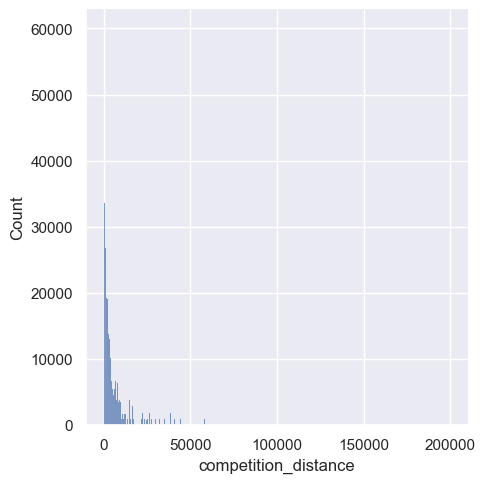

In [20]:
sns.displot(df1['competition_distance'])

# 1.7.1 Atributos Categóricos

In [21]:
cat_attributes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

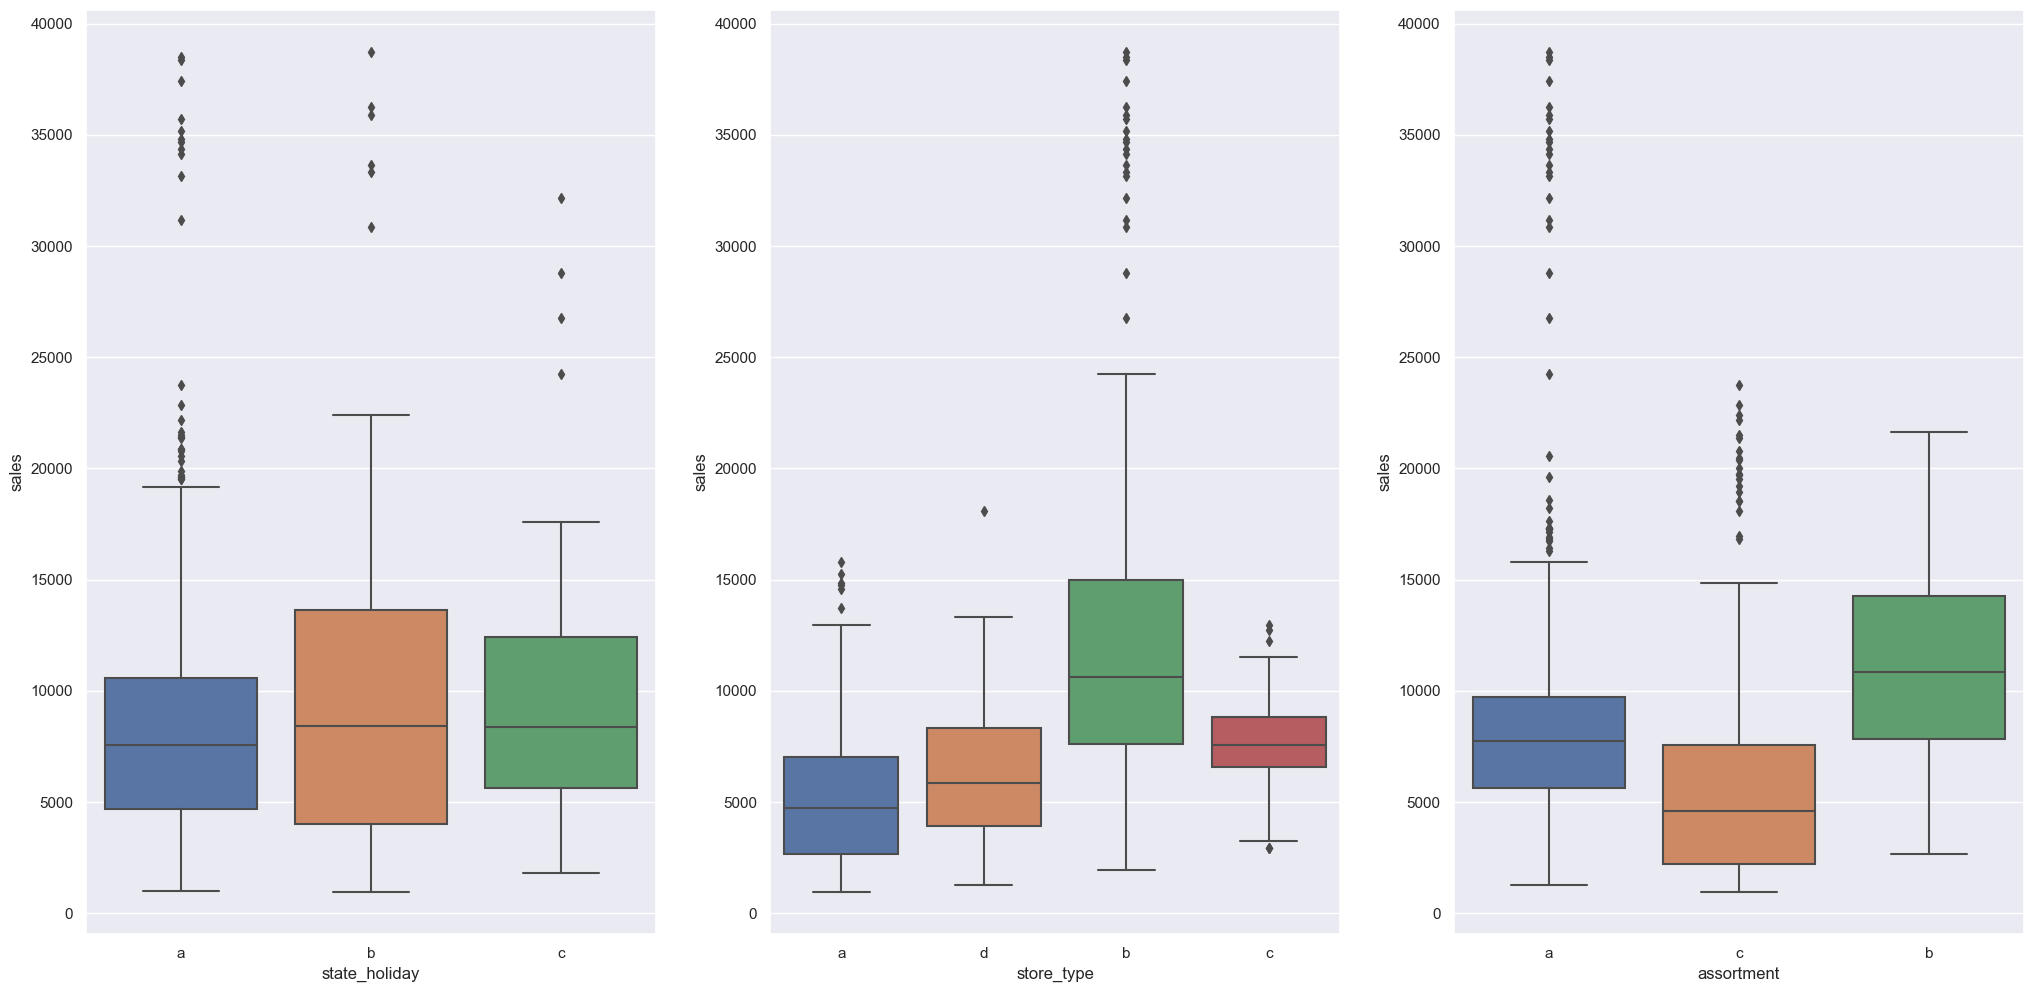

In [22]:
aux1 = df1[(df1['state_holiday']!= '0' ) & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot(x = 'state_holiday',y = 'sales',data = aux1)
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )


In [23]:
def frequency_table(data:pd.DataFrame, col:str, column:str):
    freq_table = pd.crosstab(index=data[col], columns=data[column],          margins=True)
    rel_table = round(freq_table/freq_table.loc["All"], 2)
    return freq_table, rel_table

In [24]:
a,b = frequency_table(cat_attributes,'assortment','store_type')
print(a)
print('-----------------------------------------------')
print(b)

store_type       a      b       c       d      All
assortment                                        
a           346389   6594   70878  113584   537445
b                0   8294       0       0     8294
c           205238    942   65962  199328   471470
All         551627  15830  136840  312912  1017209
-----------------------------------------------
store_type     a     b     c     d   All
assortment                              
a           0.63  0.42  0.52  0.36  0.53
b           0.00  0.52  0.00  0.00  0.01
c           0.37  0.06  0.48  0.64  0.46
All         1.00  1.00  1.00  1.00  1.00


# 2 Criação de Hipóteses

Nessa etapa, o ideal é sentar com seu time de negócios e através do mindmap, levantar hpóteses viáveis dentro do seu banco de dados

# 2.1.1 Hipoteses loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender mais

**5.** Lojas com maior sortimento deveriam vender mais

**6.** Lojas com competidores mais próximos deveriam vender menos

**7.** Lojas com competidores a mais tempo deveriam vender mais


# 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoe mais os produtos na vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas com promoções mais agressivas(descontos maiores) nos produtos deveriam vender mais

**5.** Lojas com promoções mais aativas por mais tempo nos produtos deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais


**7.** Lojas com mais promoções consecutivas deveriam vender mais


# 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender menos

**3.** Lojas que abrem nos finais de semana deveriam vender mais

**4.** Lojas abertas durante o feriado de natal deveriam vender mais

**5.** Lojas deveriam vender mais ao longo dos anos

**6.** Lojas deveriam vender mais no segundo semestre do ano

**7.** Lojas deveriam vender mais depois do dia 10 do mês

**8.** Lojas deveriam vender menos aos finais de semana

**9.** Lojas deveriam vender menos durante feriados escolares



# 2.2 Lista final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais


**4.** Lojas com promoções mais aativas por mais tempo nos produtos deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais


**6.** Lojas com mais promoções consecutivas deveriam vender mais


**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 do mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante feriados escolares

# 2.3 Feature Engineering

In [25]:
df2 = df1.copy()

In [26]:
#year
df2['year'] = df2['date'].dt.year
#month

df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS






In [28]:
df3 = df2.copy()

# 3.1. Filtragem das Linhas

In [29]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

# 3.2. Seleção das Colunas

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Análise exploratória de dados


In [31]:
df4 = df3.copy()

# 4.1. Análise univariada

# 4.1.1 Variável de Resposta

<AxesSubplot:xlabel='sales', ylabel='Density'>

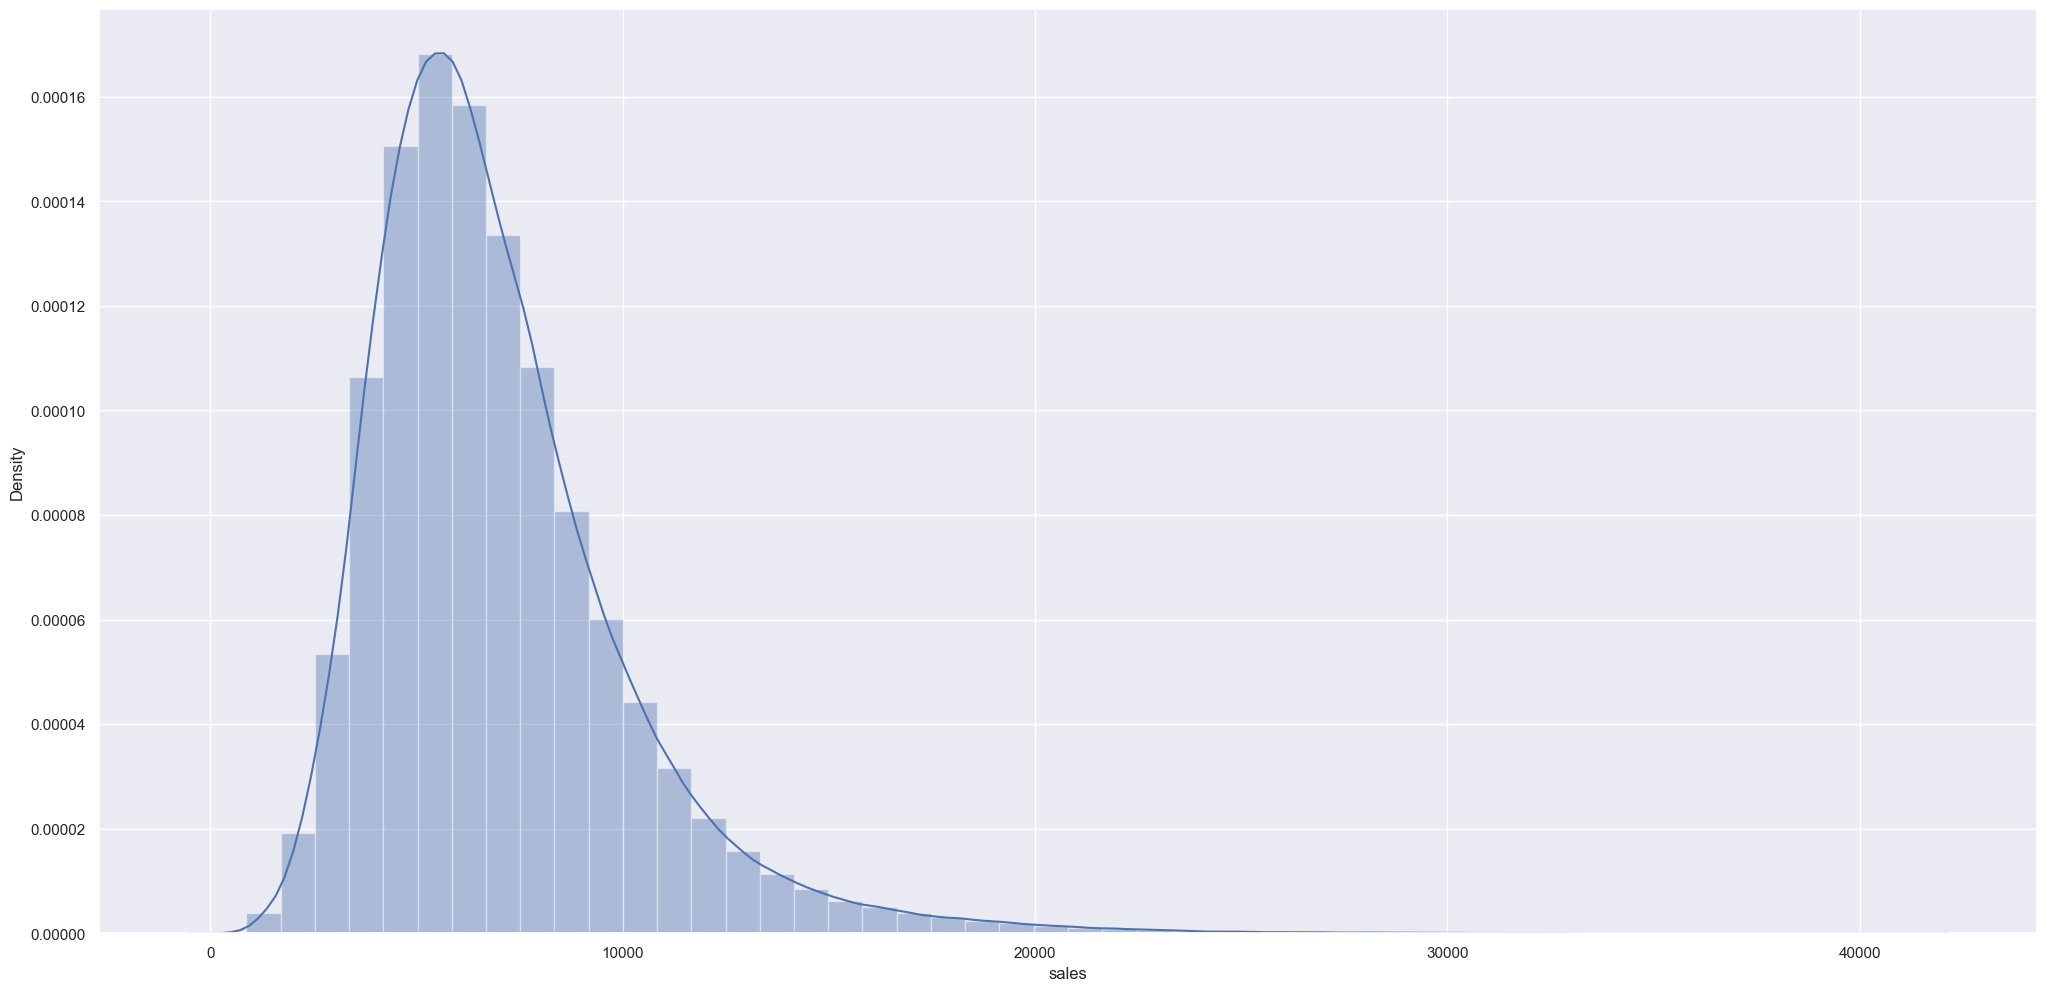

In [32]:
sns.distplot(df4['sales'])

# 4.1.2 Variáveis numéricas

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

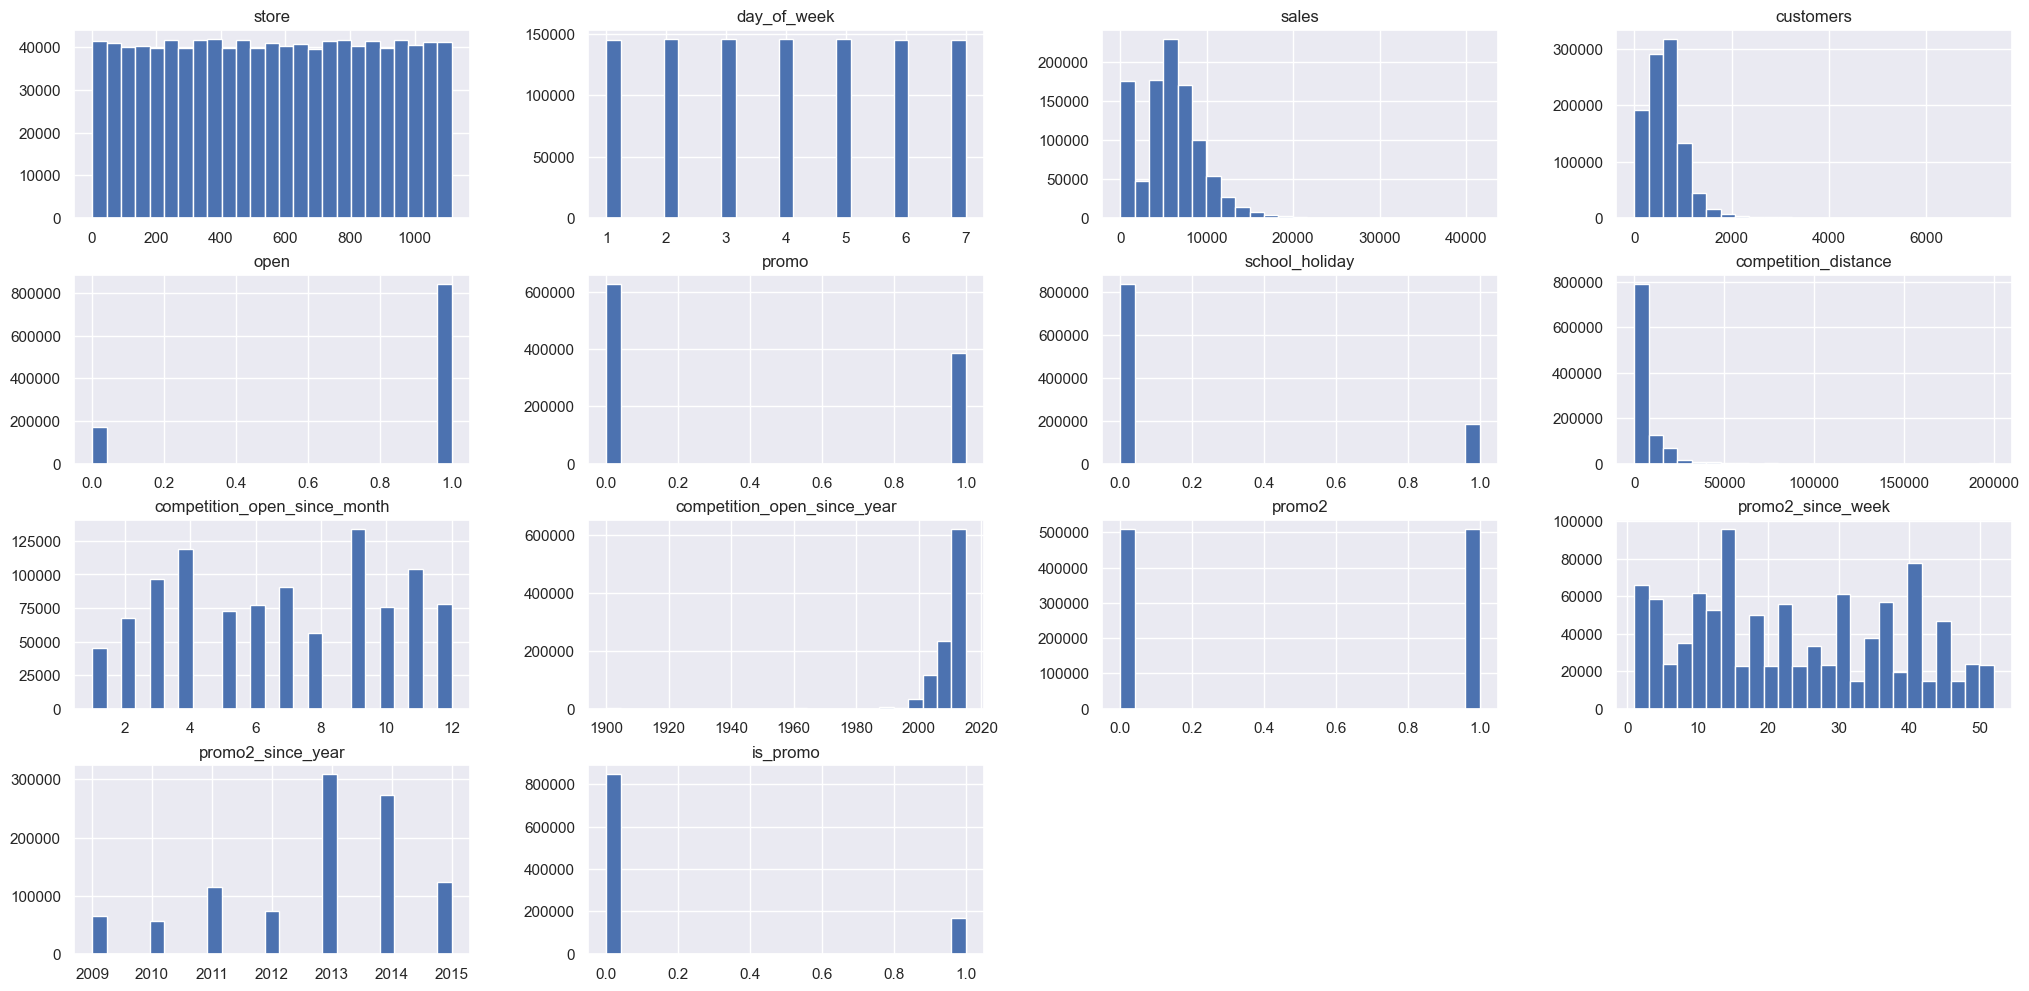

In [33]:
num_attributes.hist(bins = 25)

# 4.1.3 Variáveis Categóricas

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [35]:
#verificando quanto que tem em cada variavel categorica
df4['state_holiday'].value_counts(normalize = True)
df4['store_type'].value_counts(normalize = True)
df4['assortment'].value_counts(normalize = True)

basic       0.526892
extended    0.463386
extra       0.009722
Name: assortment, dtype: float64

<AxesSubplot:xlabel='sales', ylabel='Density'>

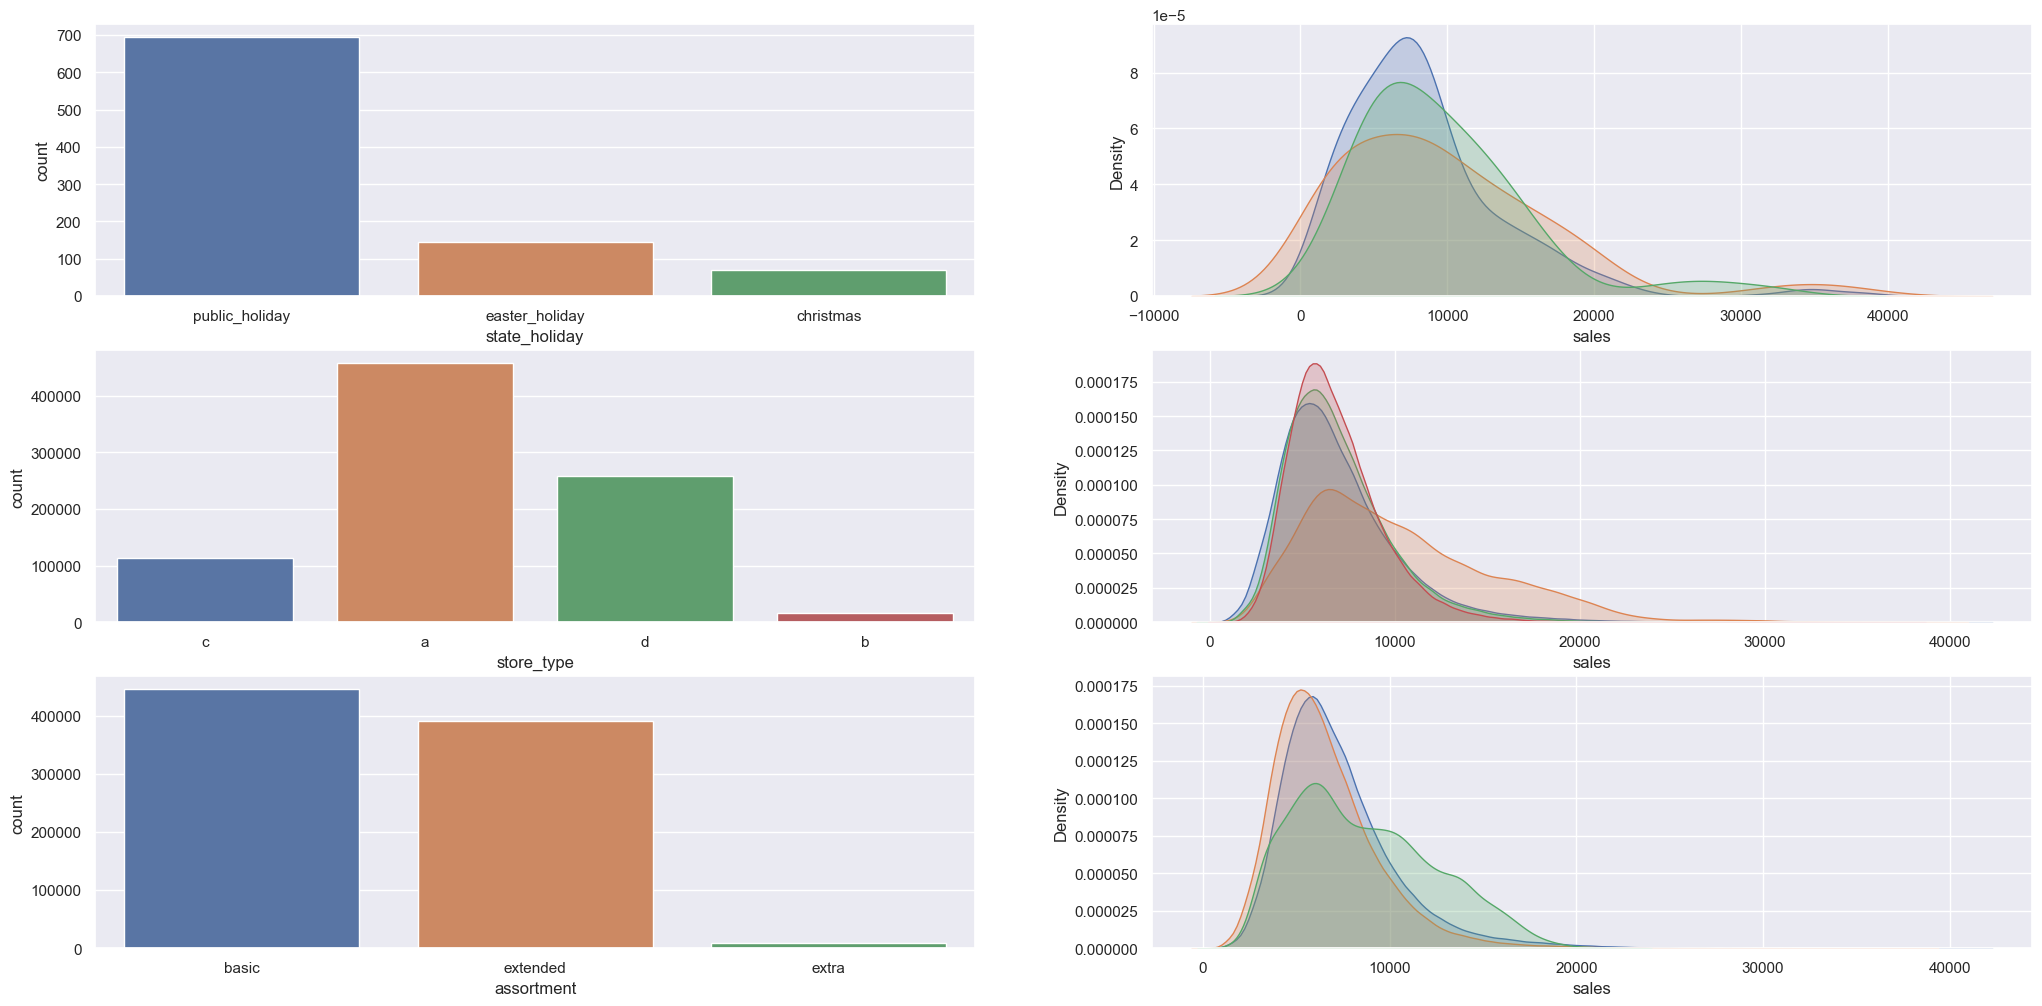

In [36]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday']!='regular_day']
sns.countplot(data = a , x = 'state_holiday')
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label = 'public_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label = 'easter_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label = 'christmas',shade = True)
#store_type
plt.subplot(3,2,3)
sns.countplot(data = df4,x = 'store_type')
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label = 'a',shade = True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label = 'b',shade = True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label = 'c',shade = True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label = 'd',shade = True)


#assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label = 'extended',shade = True)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label = 'basic',shade = True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label = 'extra',shade = True)



# 4.2 Análise Bivariada

# h1. Lojas com maior sortimento deveriam vender mais
**Falso** Lojas com MAIS SORTIMENTO VENDEM MENOS

<AxesSubplot:xlabel='year_week'>

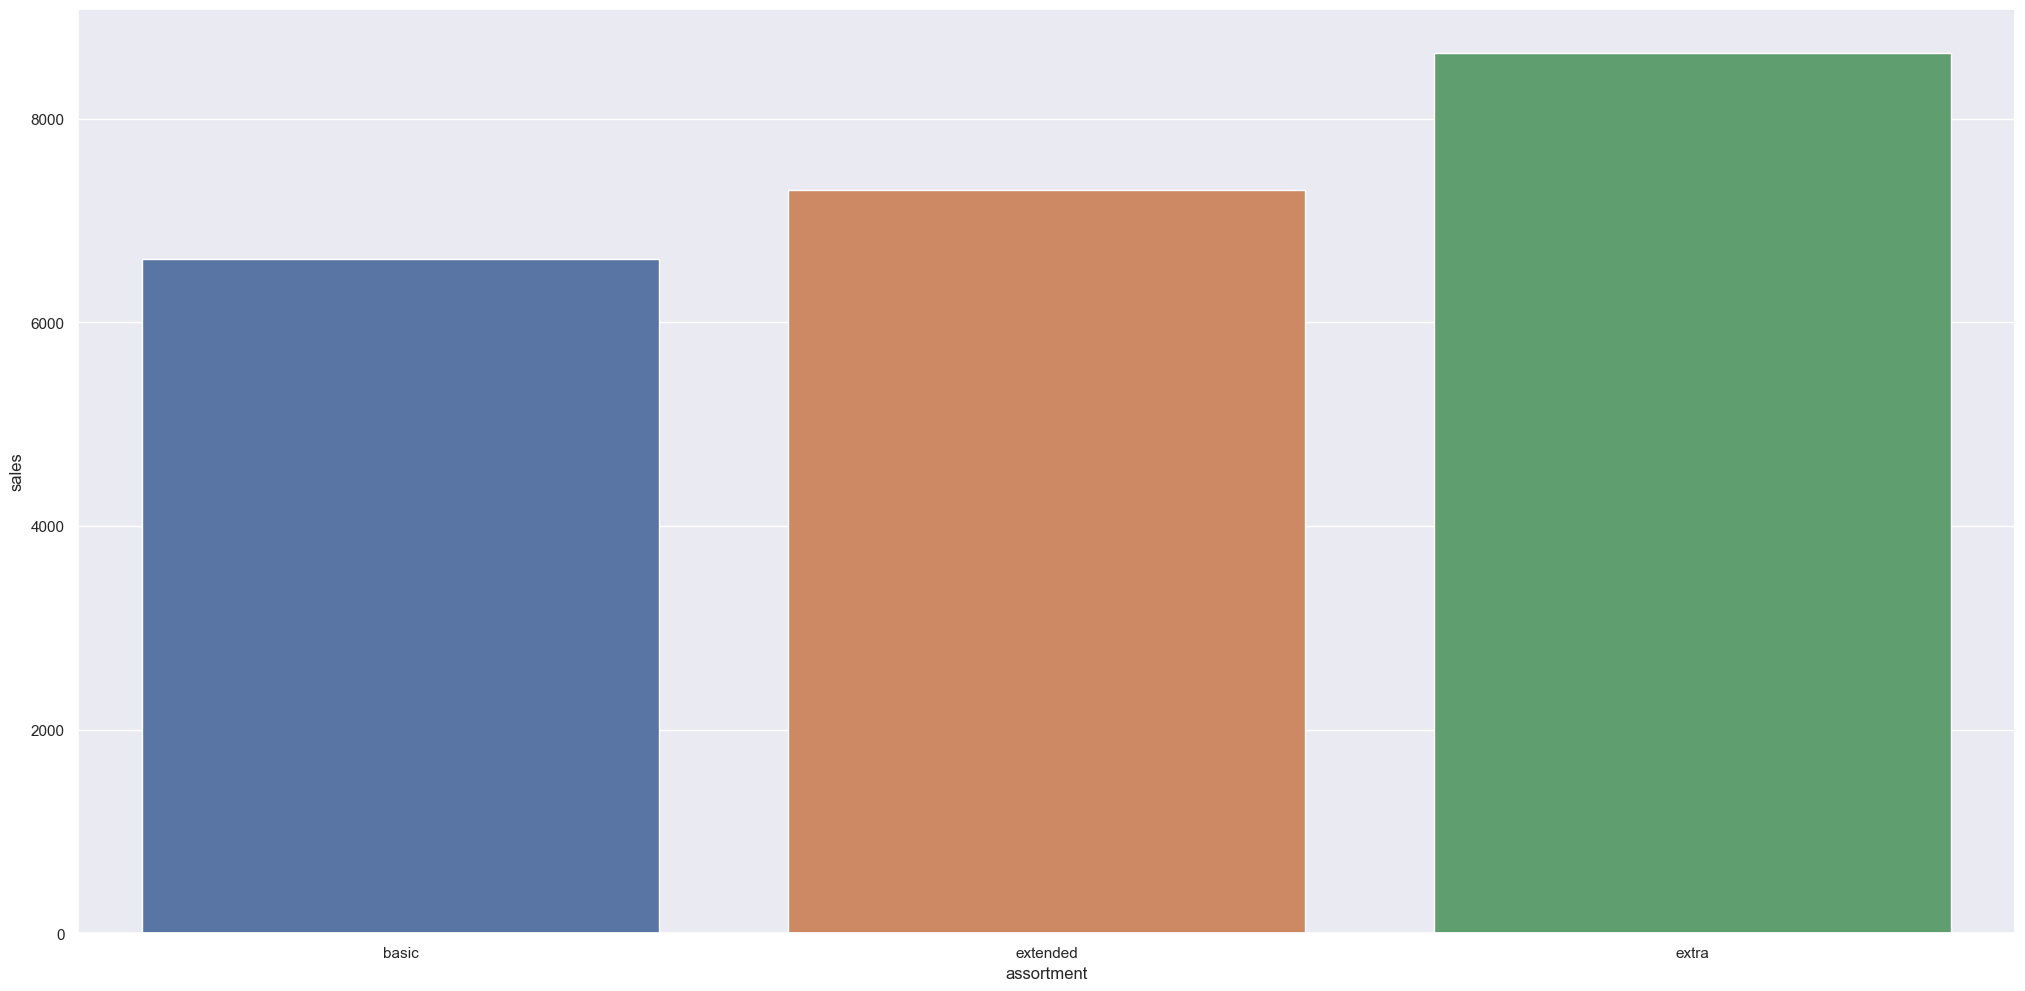

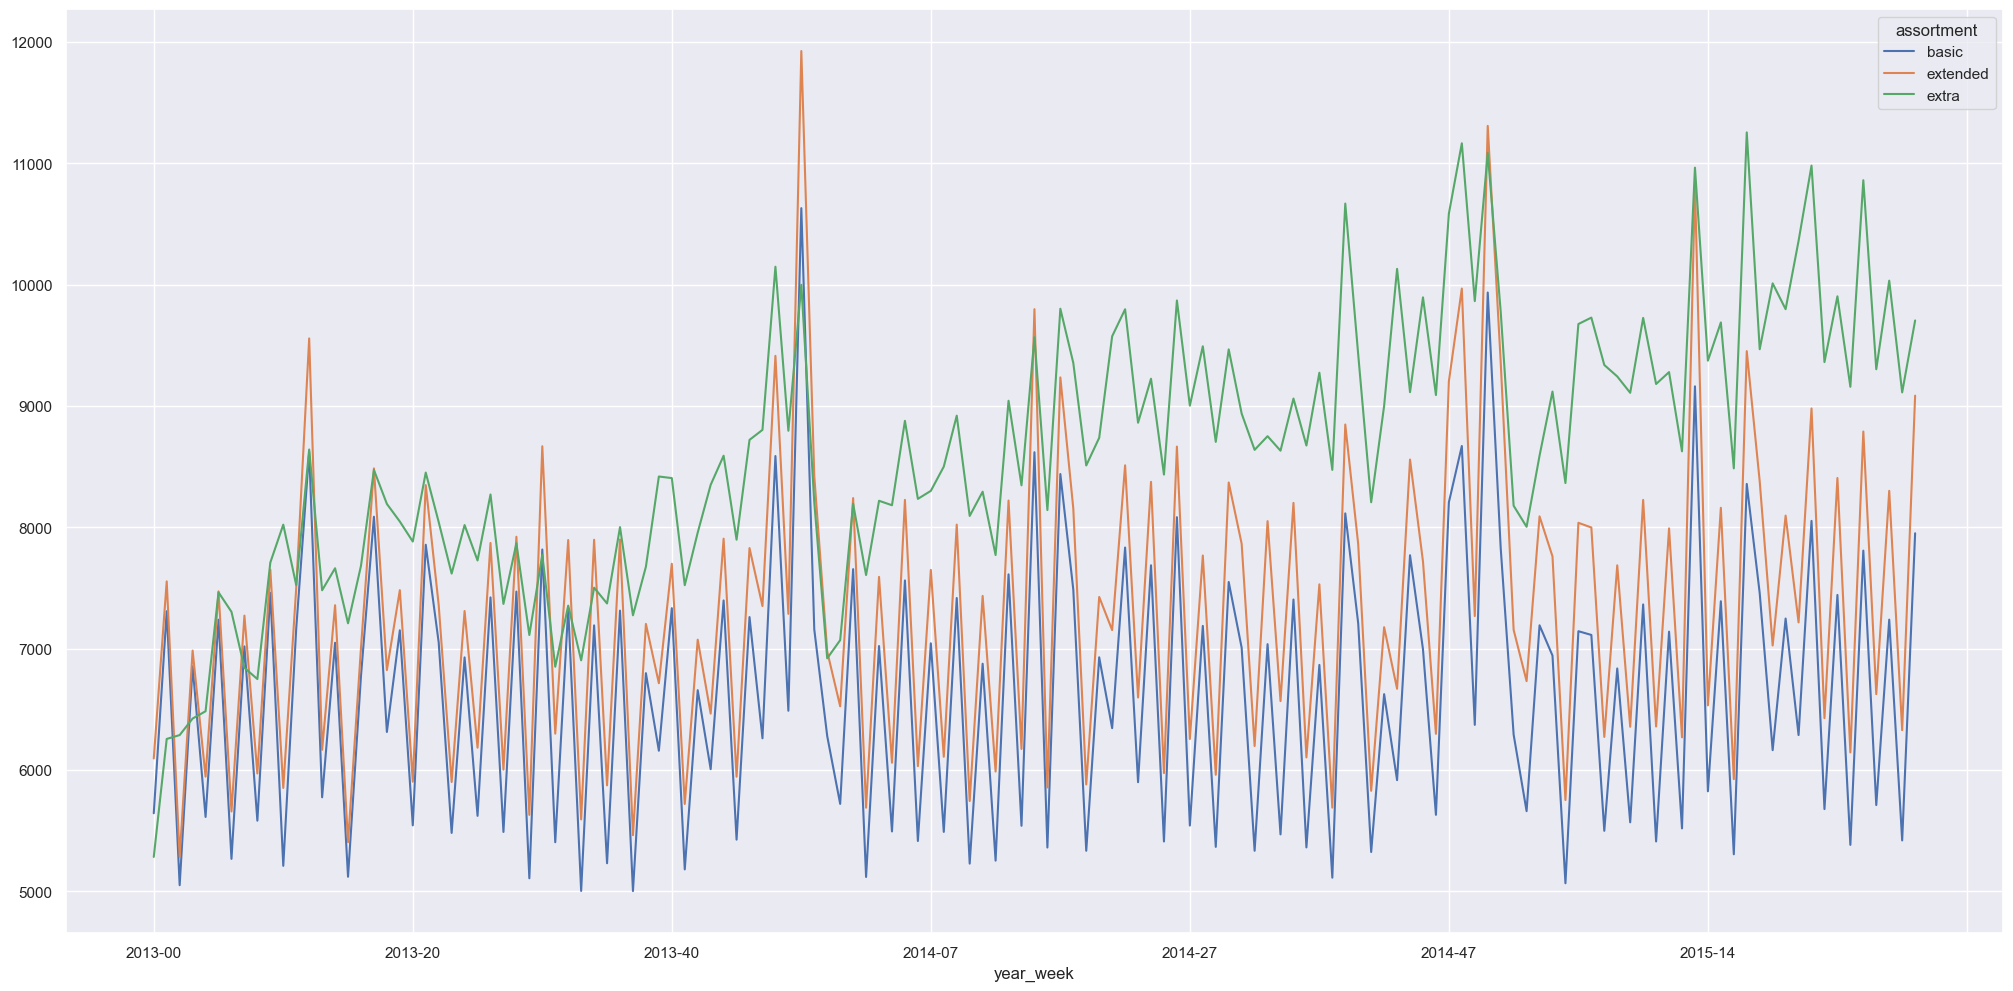

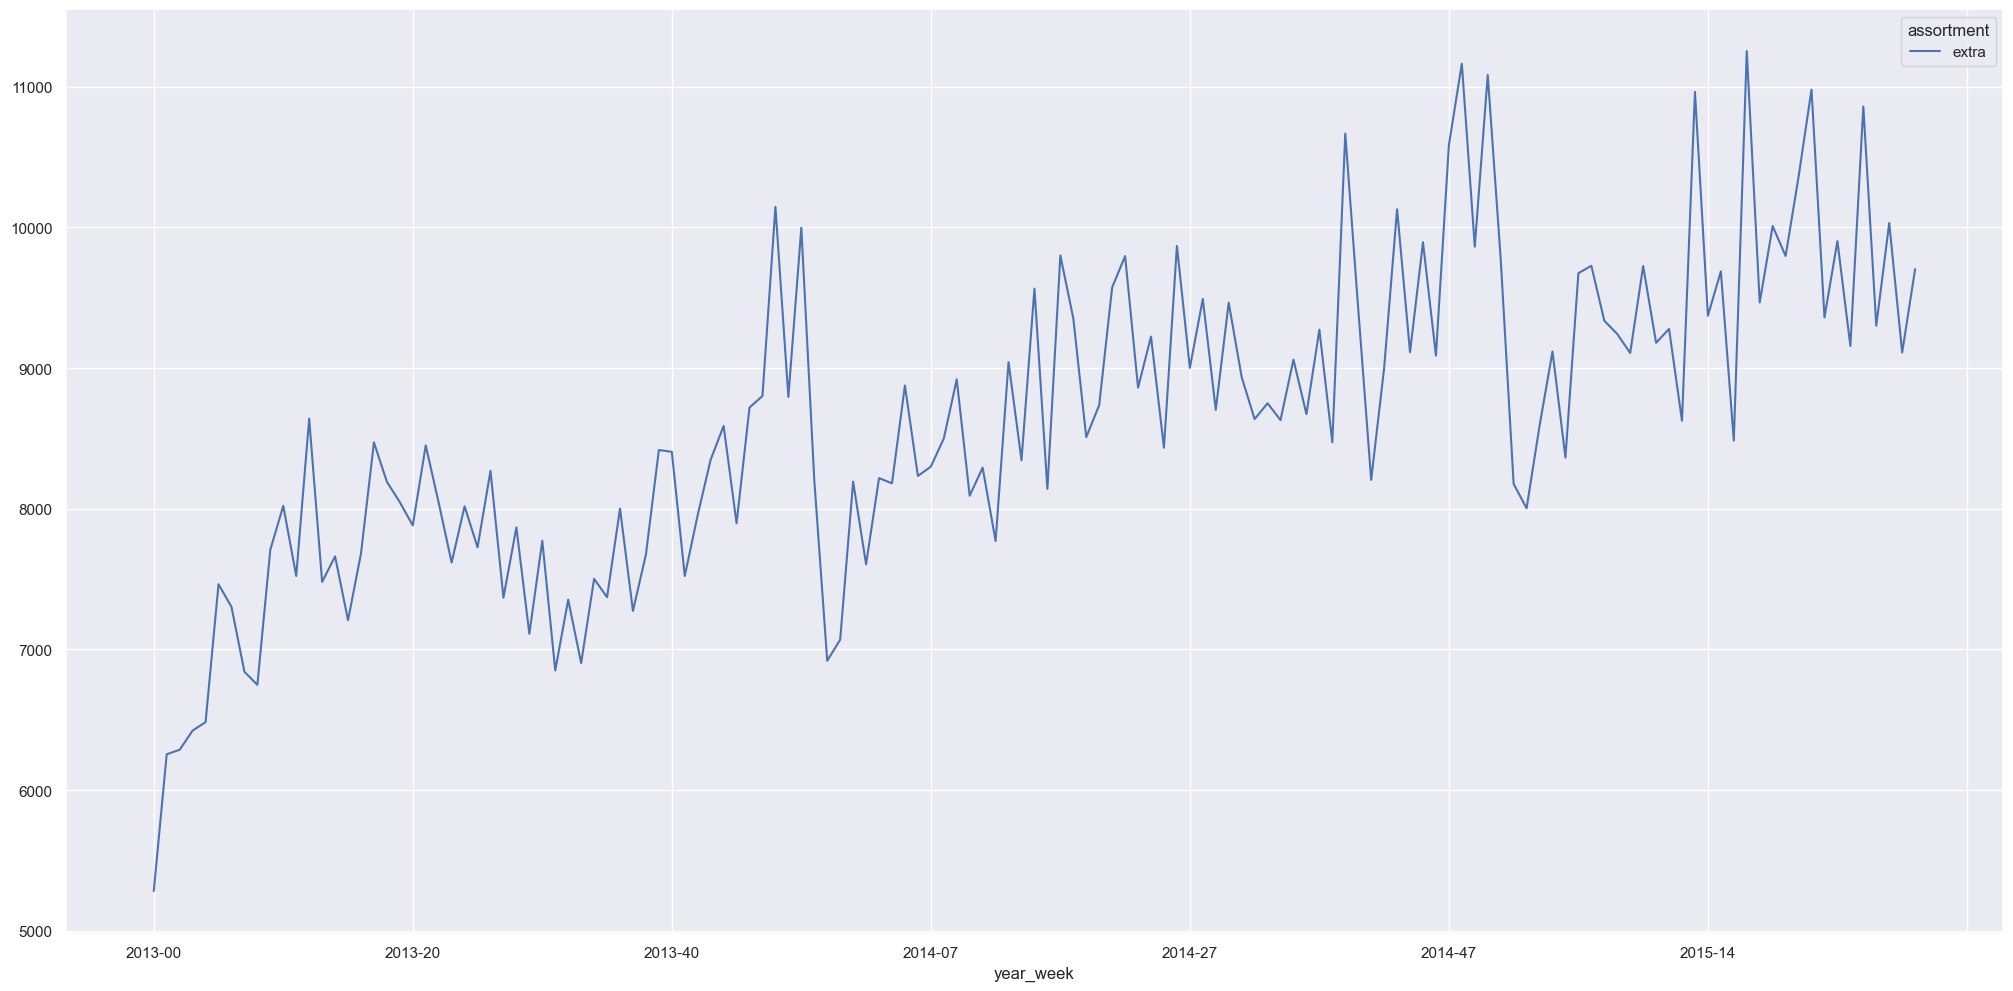

In [37]:
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x = 'assortment', y='sales', data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week',columns='assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns='assortment', values = 'sales').plot()

# h2. Lojas com competidores mais próximos deveriam vender menos
**Falsa**.Por média, vendem na mesma faixa de números.


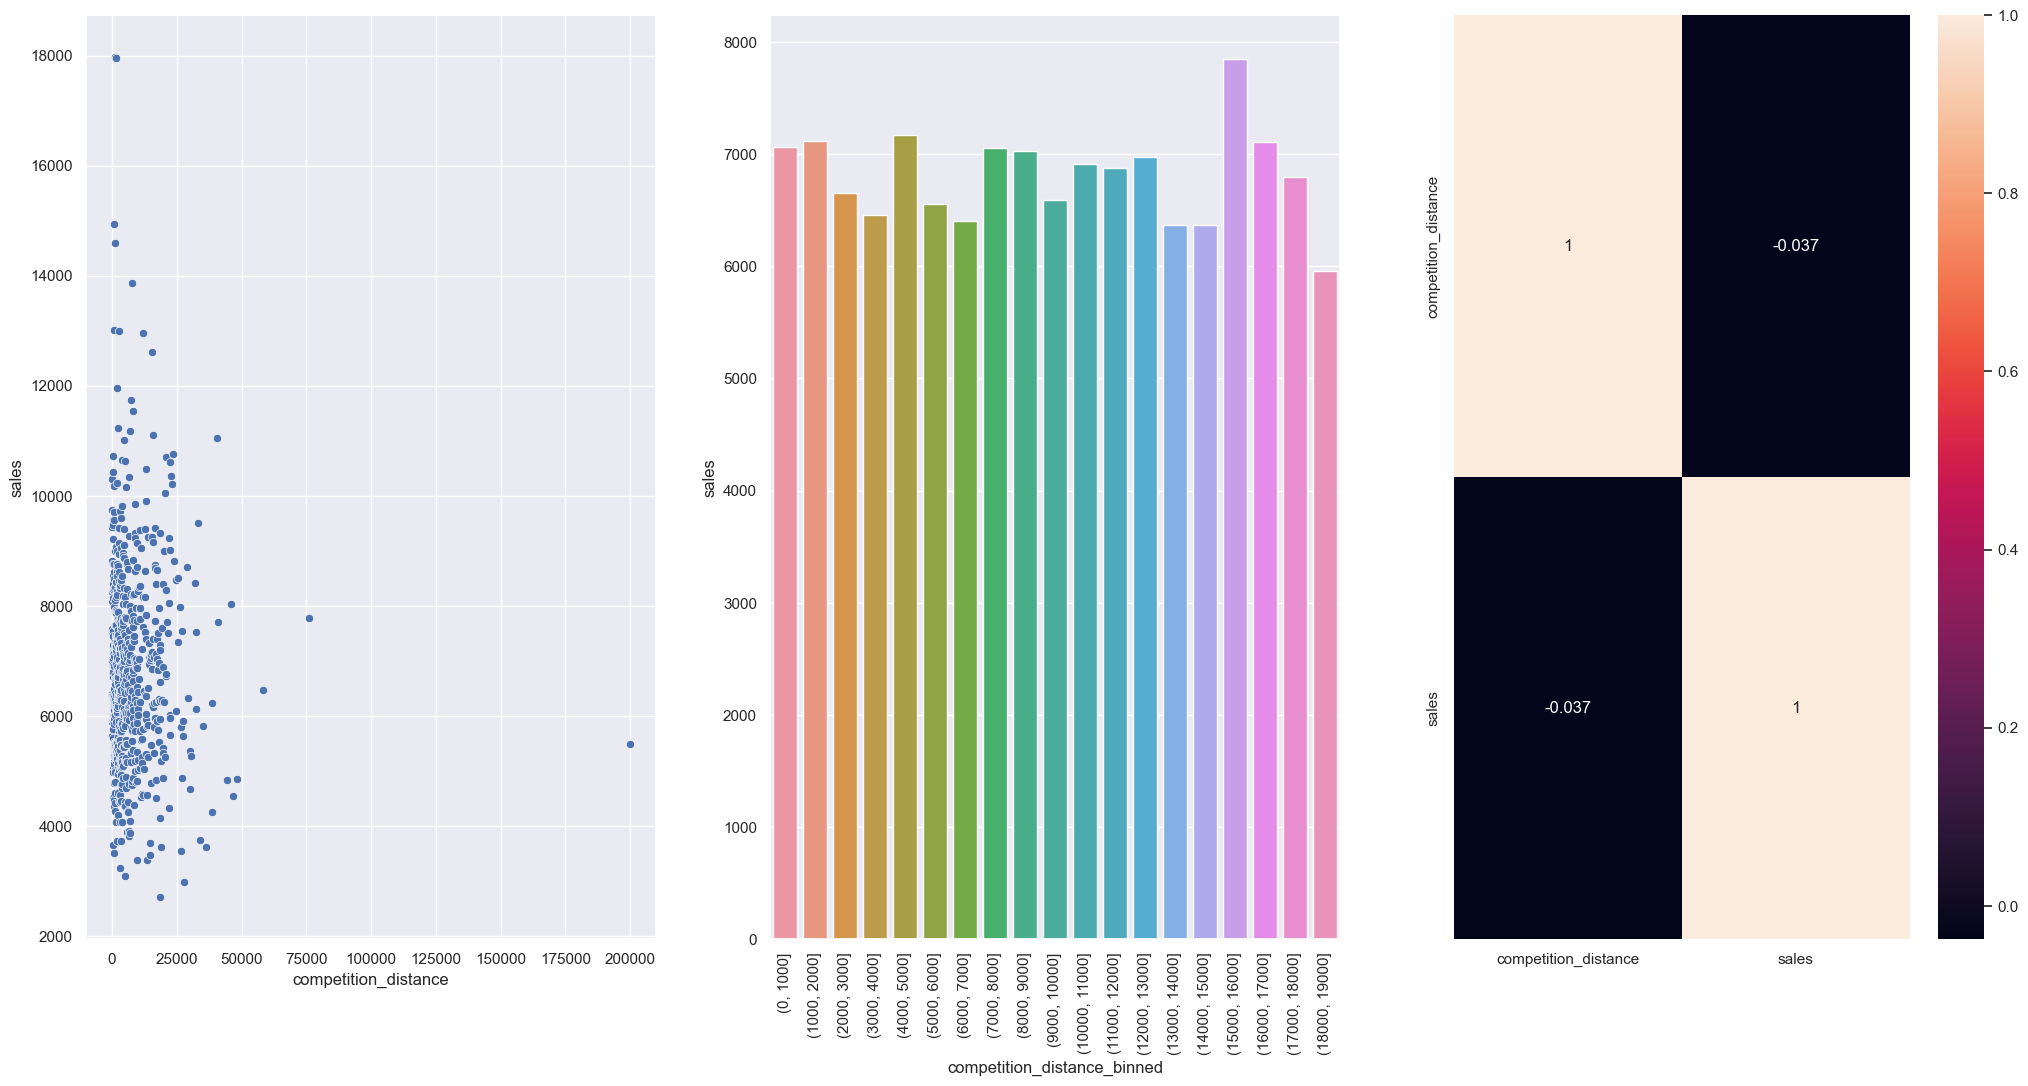

In [38]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1);
plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


# h3. Lojas com competidores a mais tempo deveriam vender mais
**Falso** Lojas com competidores a mais tempo VENDEM MENOS

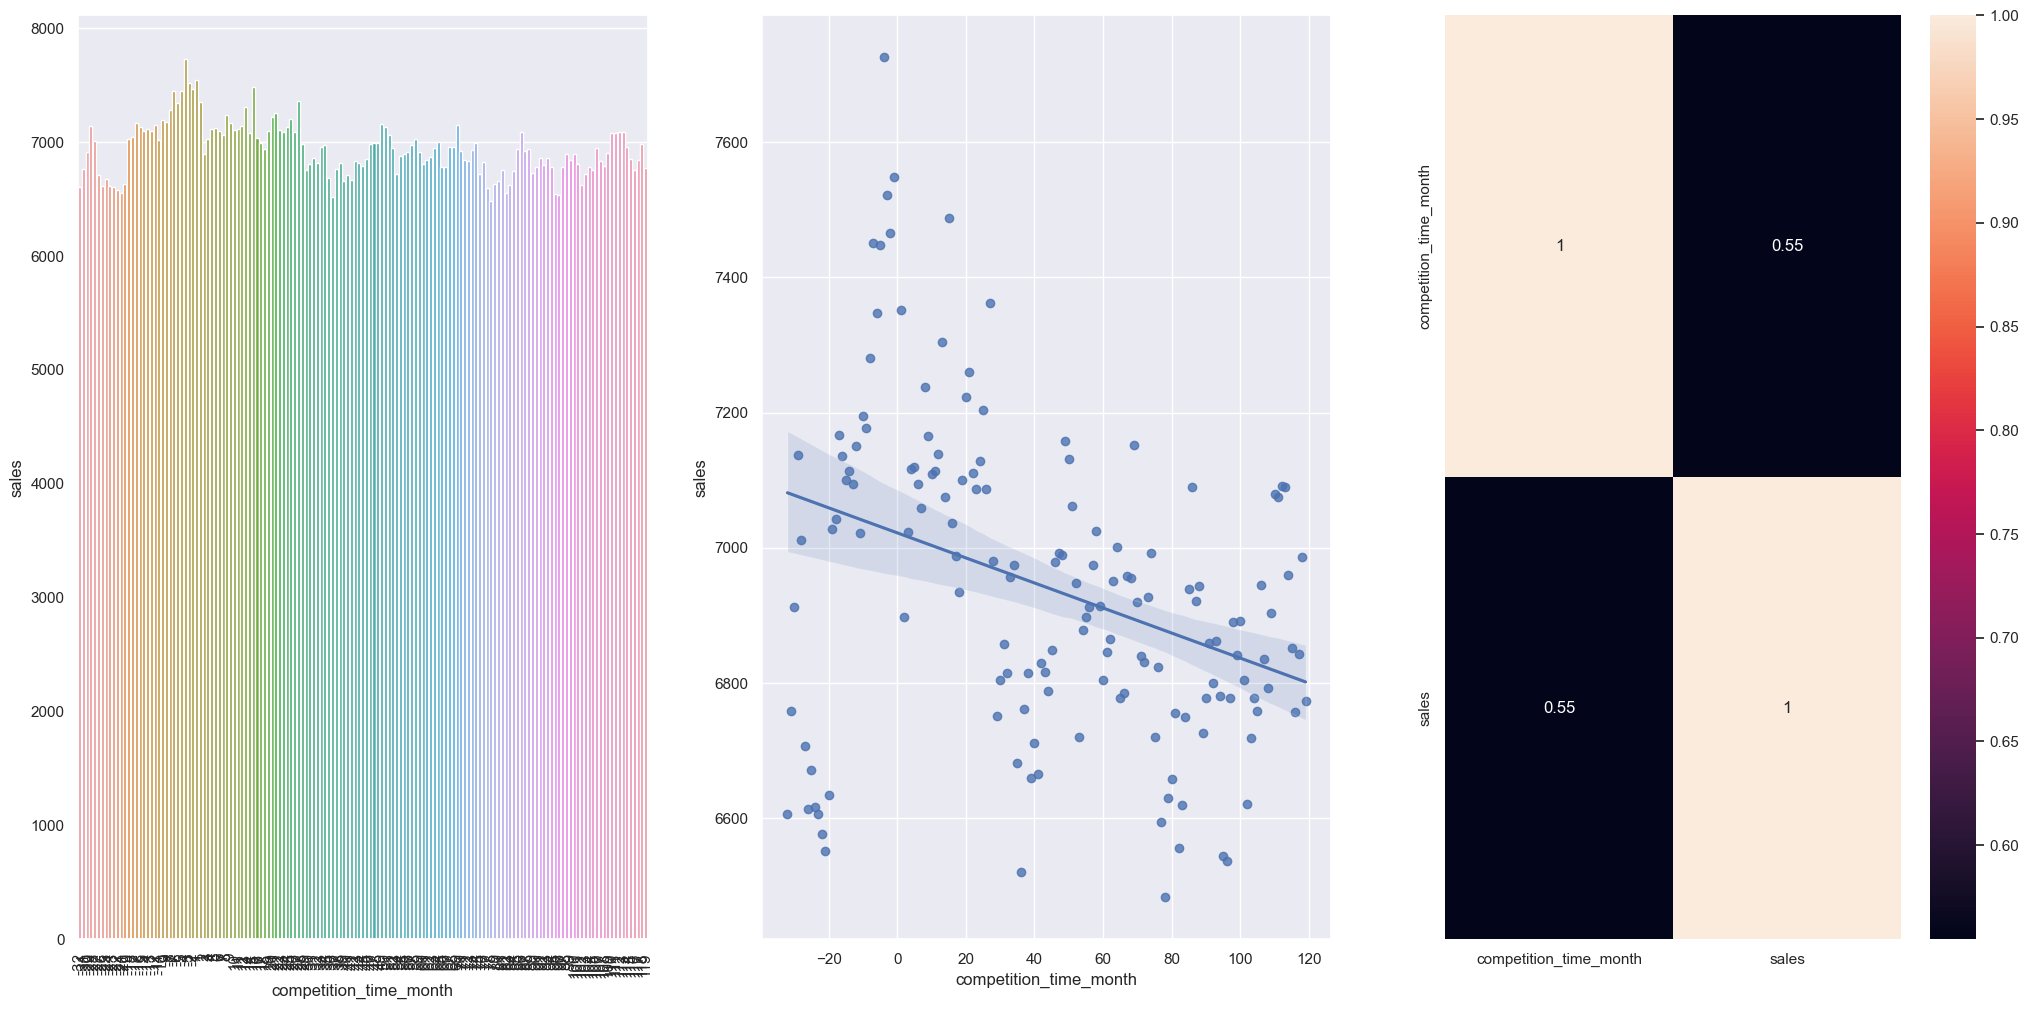

In [39]:
#aux1 = df4[['competition_open_since_month','sales']].groupby('competition_open_since_month').sum().reset_index()
#sns.barplot(x = 'competition_open_since_month',y = 'sales',data = aux1);
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <  120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month',y = 'sales',data = aux2);
plt.xticks(rotation = 90);
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y = 'sales',data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

# H4 Lojas com promoções mais ativas por mais tempo nos produtos deveriam vender mais
**Falsa** As lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção


In [40]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


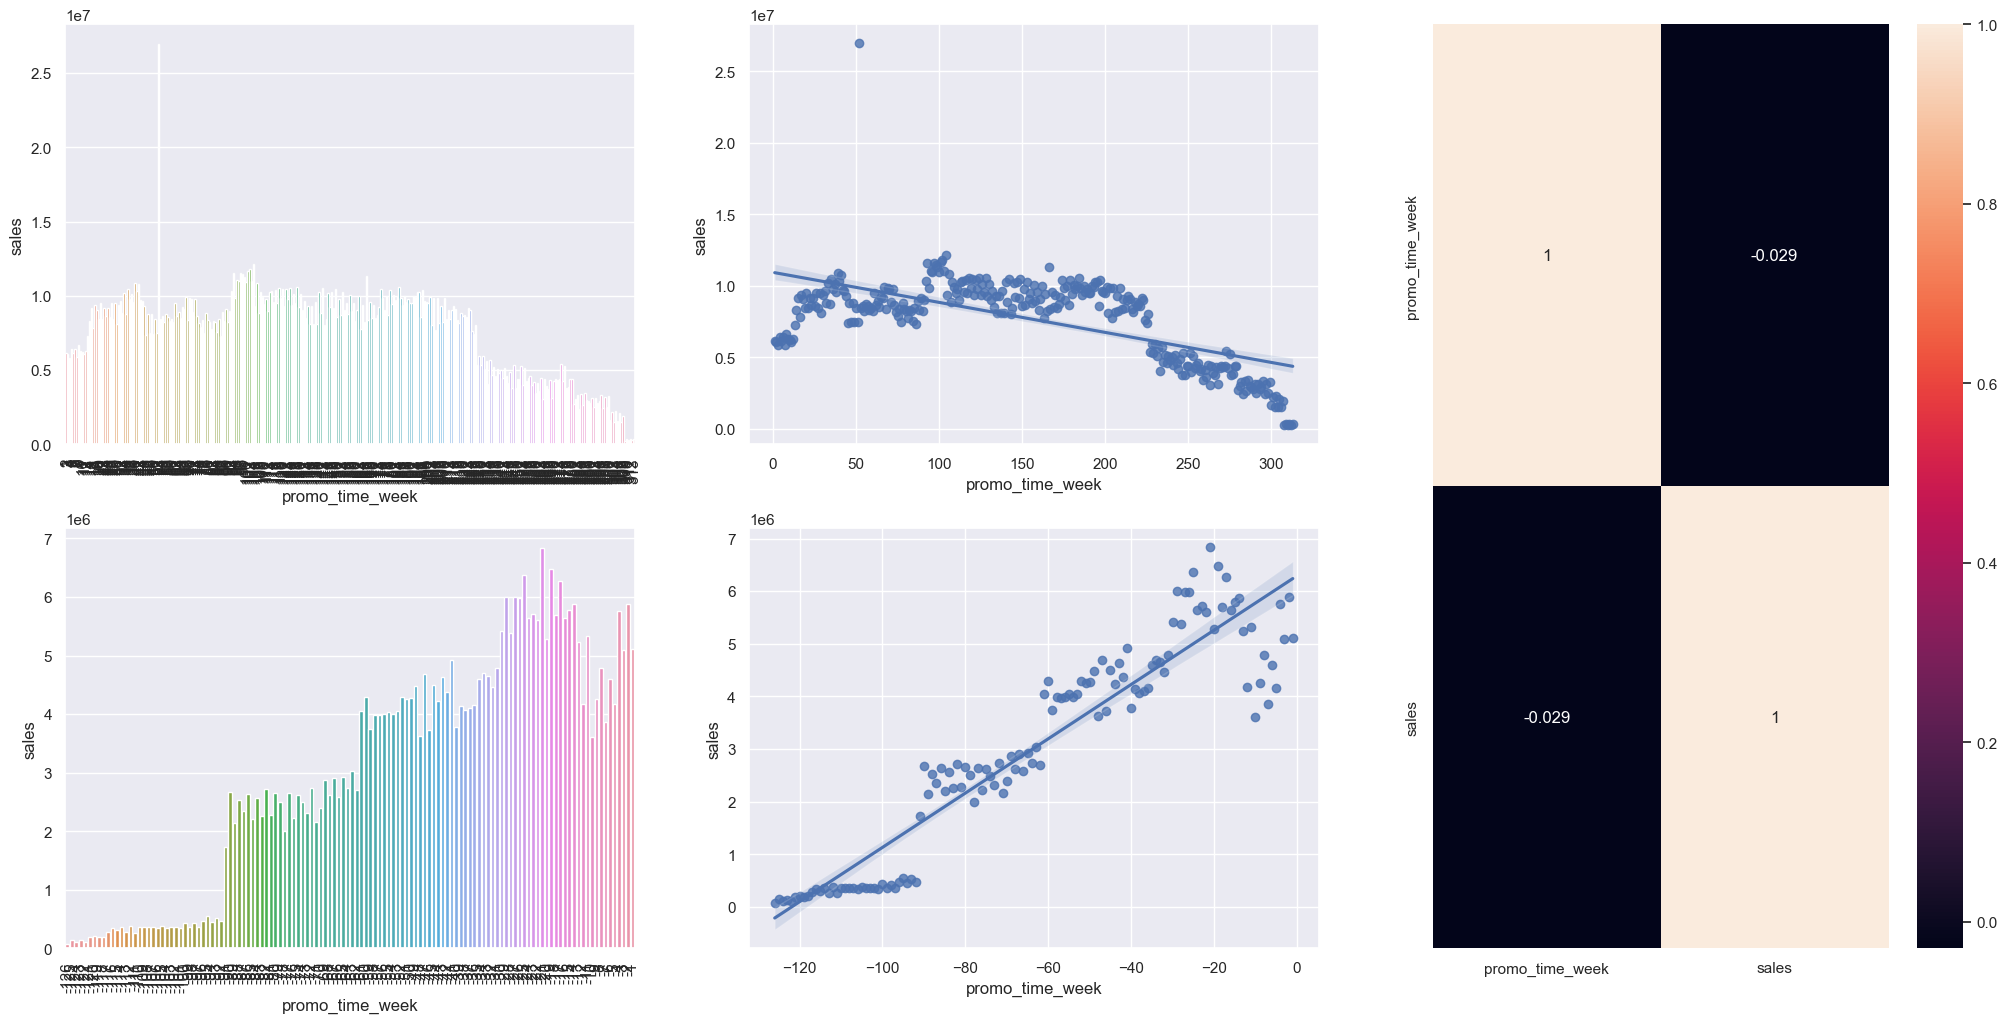

In [41]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[: , 2])
sns.heatmap(aux1.corr(method = 'pearson'),annot = True);

# H5 Lojas com mais promoções consecutivas deveriam vender mais
**Falso** Lojas com promoções consecutivas vendem menos

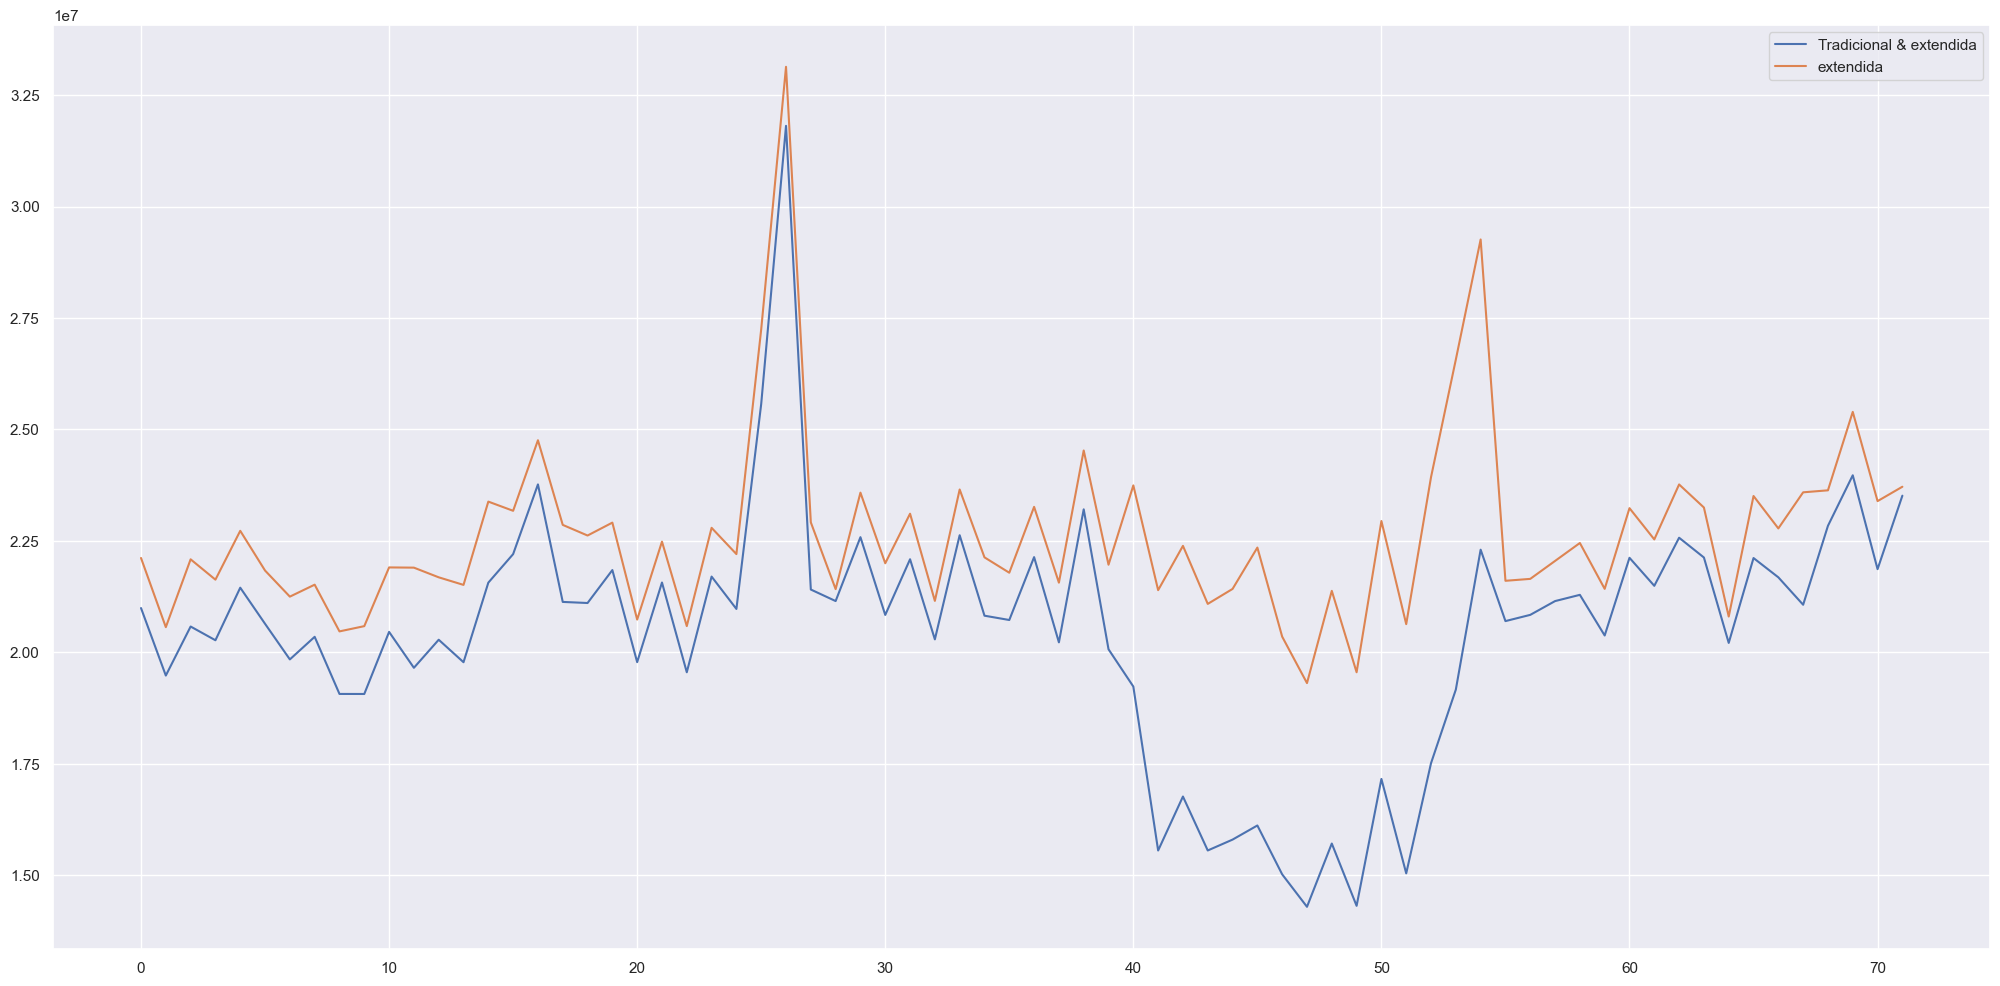

In [42]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()
aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels = ['Tradicional & extendida','extendida']);

# h6. Lojas abertas durante o feriado de natal deveriam vender mais
**Verdadeiro** Lojas abertas durante o natal vendem mais que os dias regulares

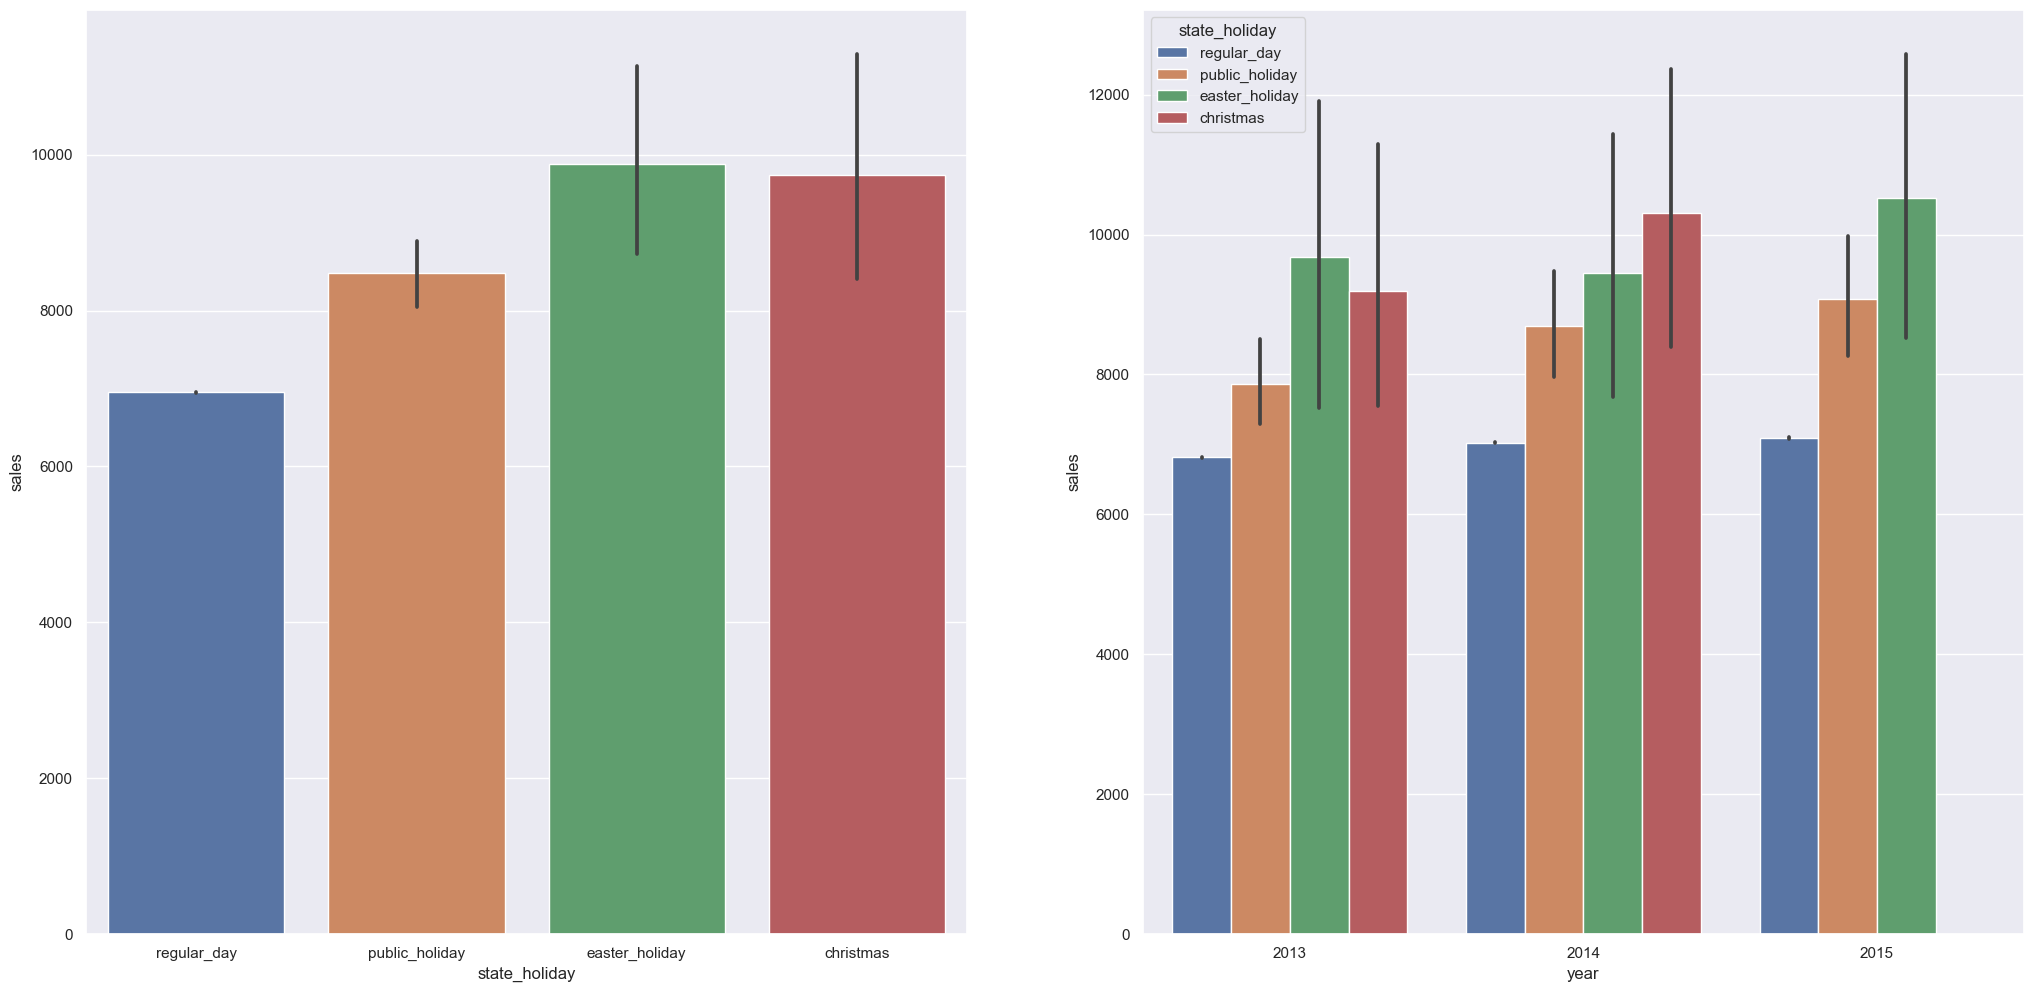

In [43]:

plt.subplot(1,2,1)
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x = 'state_holiday',y='sales', data = df4);

plt.subplot(1,2,2)
aux2 = df4[['year','state_holiday','sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x = 'year',y='sales',hue = 'state_holiday', data = df4);

# h7. Lojas deveriam vender mais ao longo dos anos
**Falso** Nos dois anos COMPLETOS abrangidos pelo dataset, as vendas diminuíram

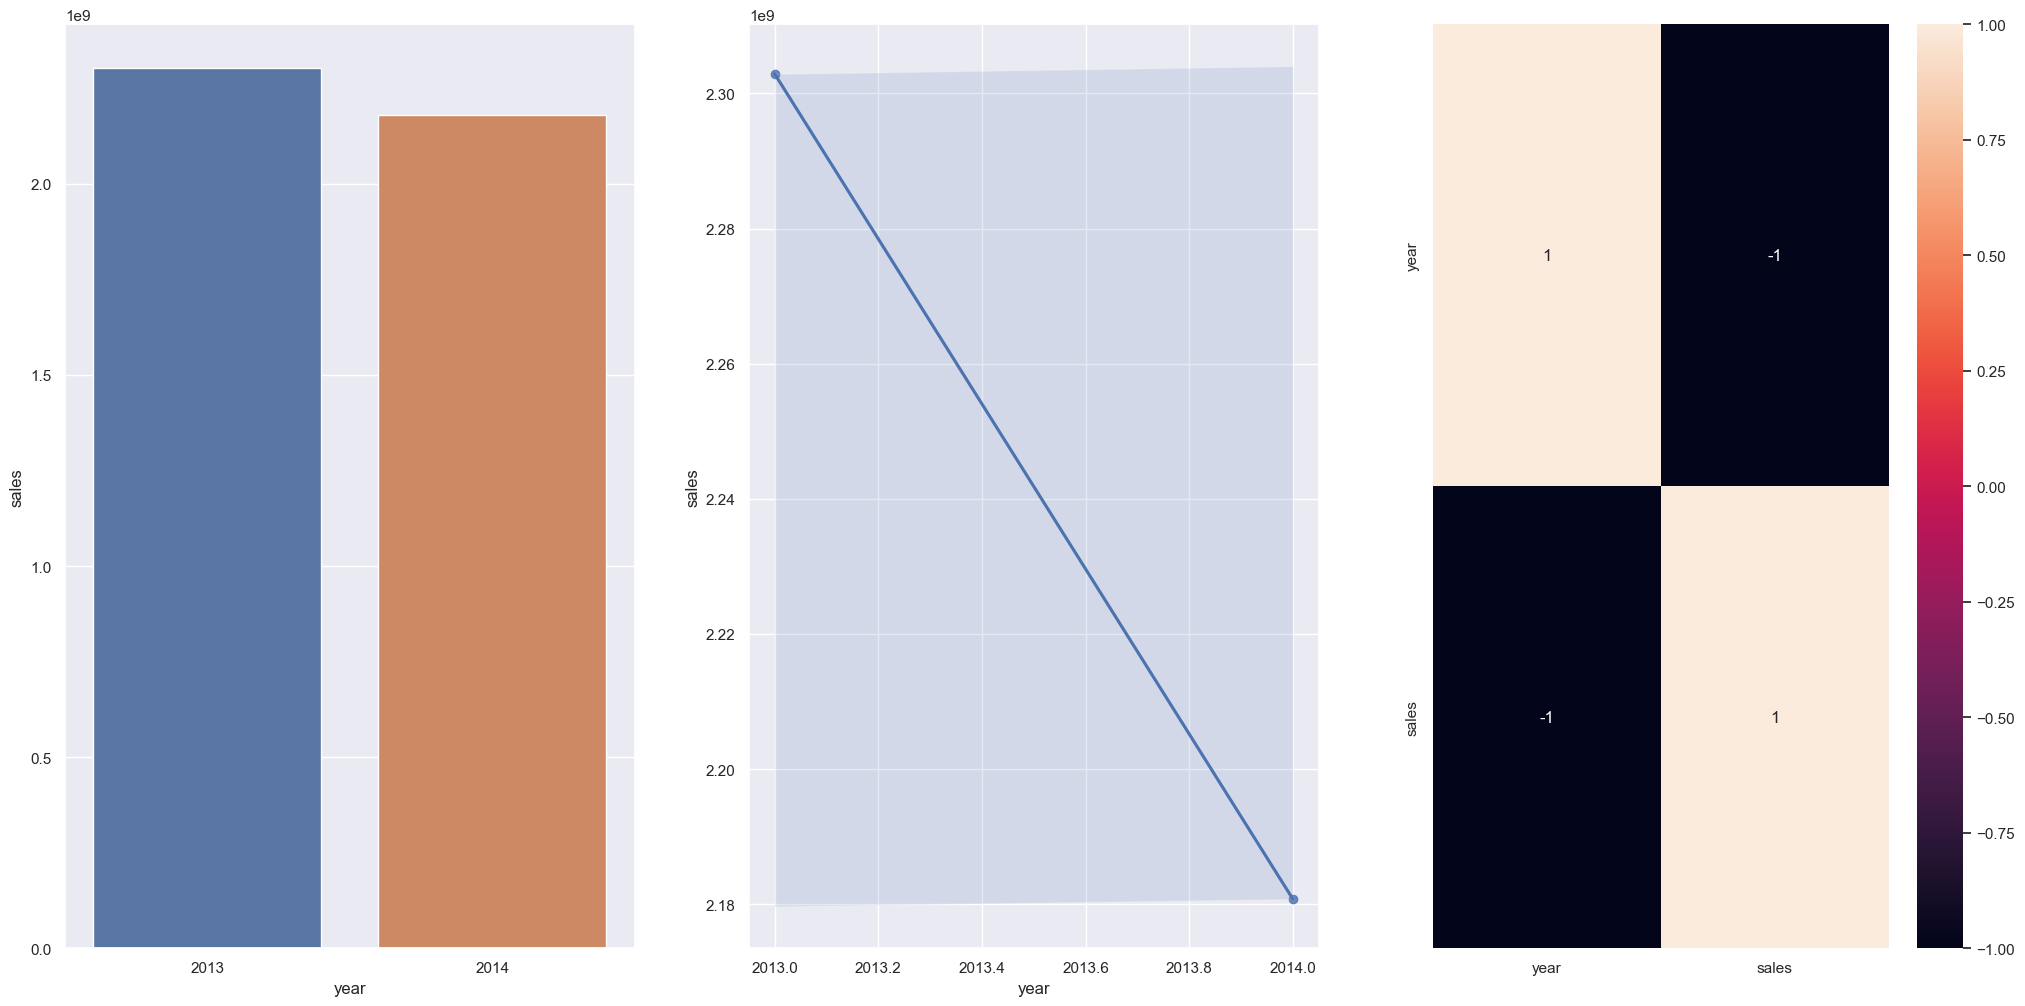

In [44]:
a = df4[df4['year'] != 2015 ]
aux1 = a[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# h8 Lojas deveriam vender mais no segundo semestre do ano
**Verdadeiro** Lojas vendem mais no segundo semestre

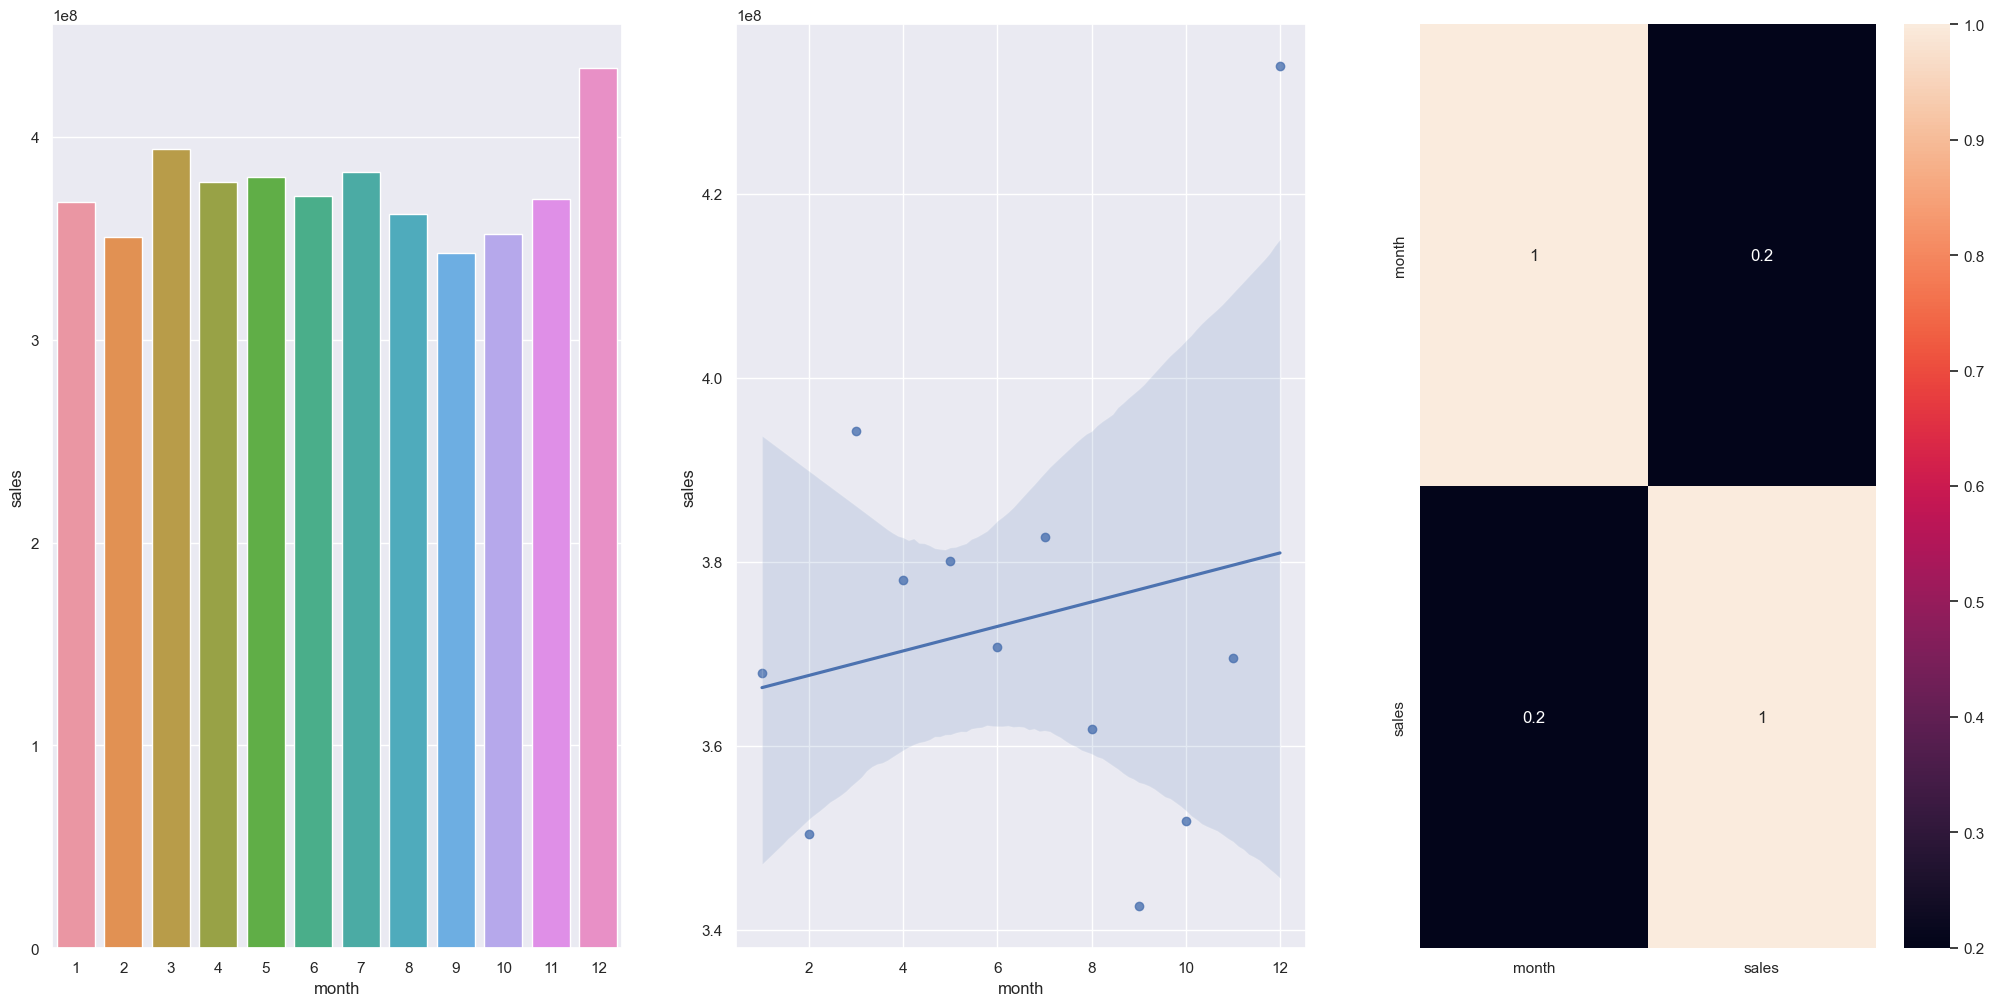

In [45]:
aux = df4[df4['year'] < 2015]
aux1 = aux[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# h9 Lojas deveriam vender mais depois do dia 10 do mês
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

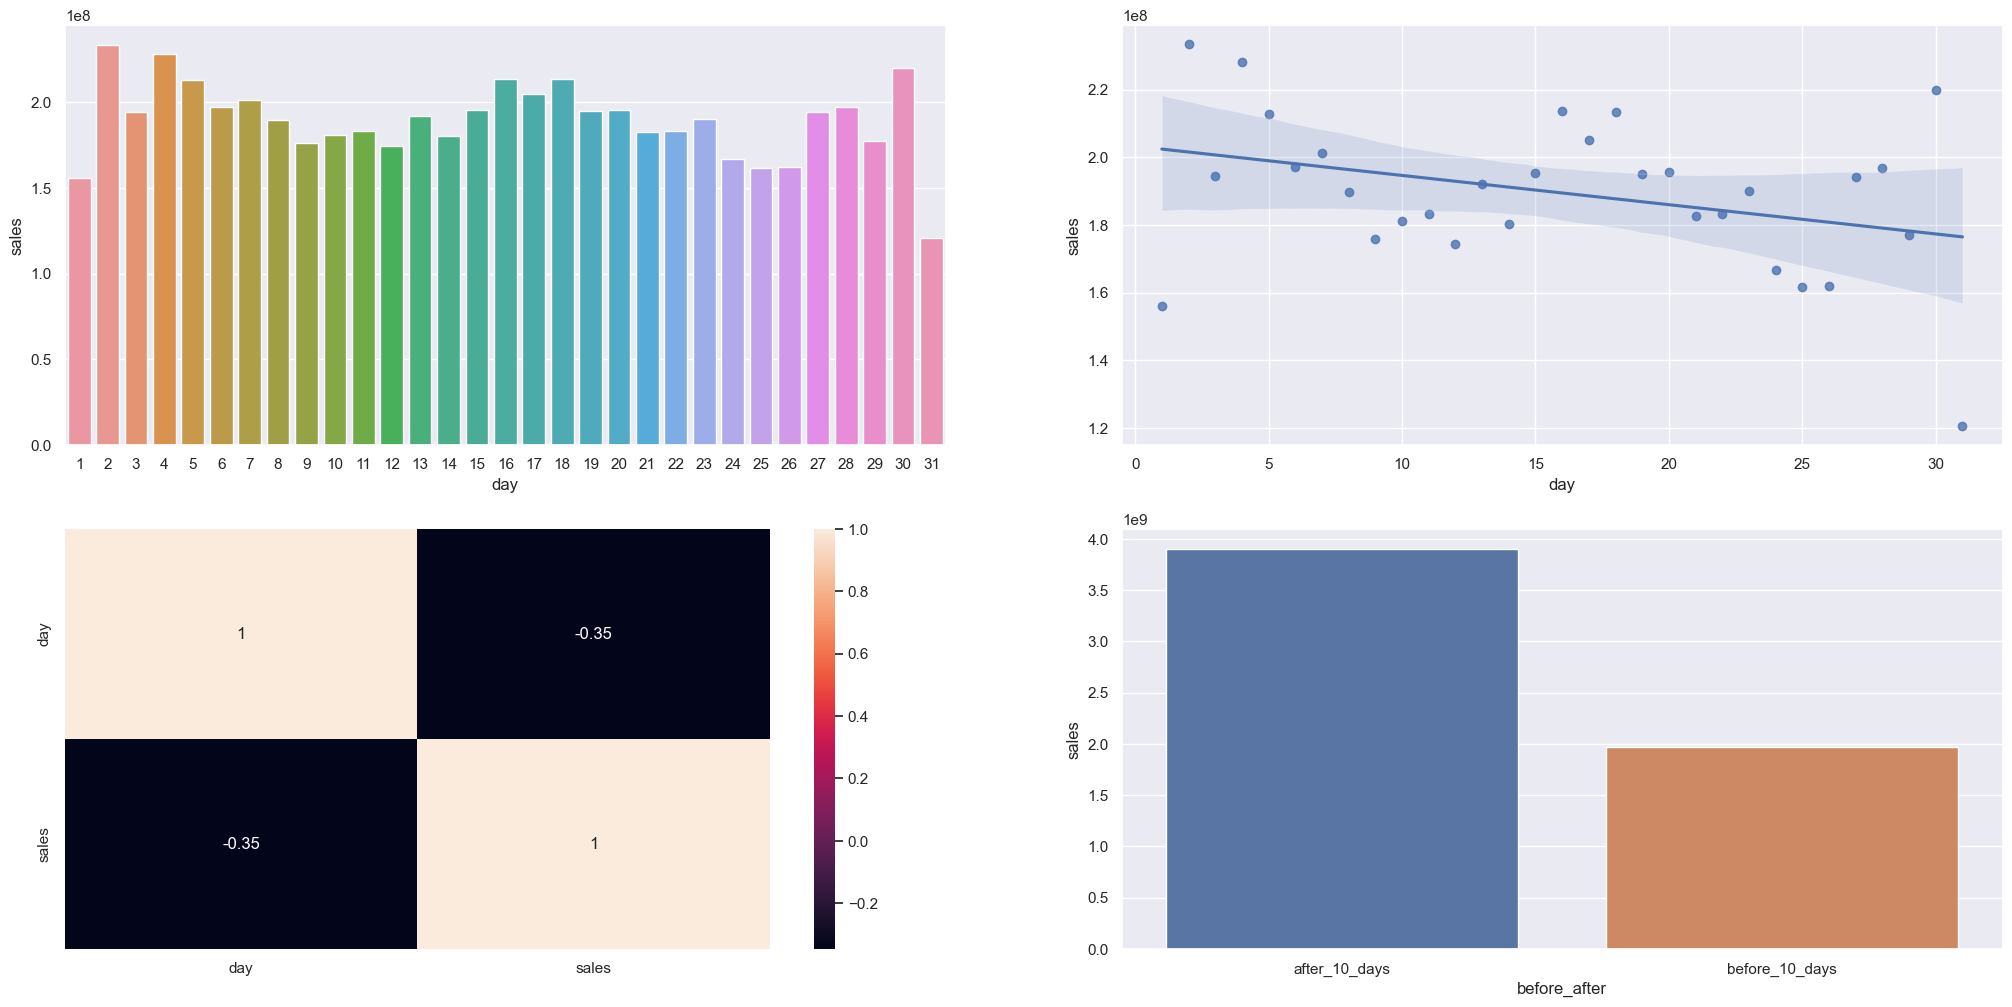

In [46]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

# h10. Lojas deveriam vender menos aos finais de semana

**VERDADEIRA** Lojas vendem menos nos final de semana

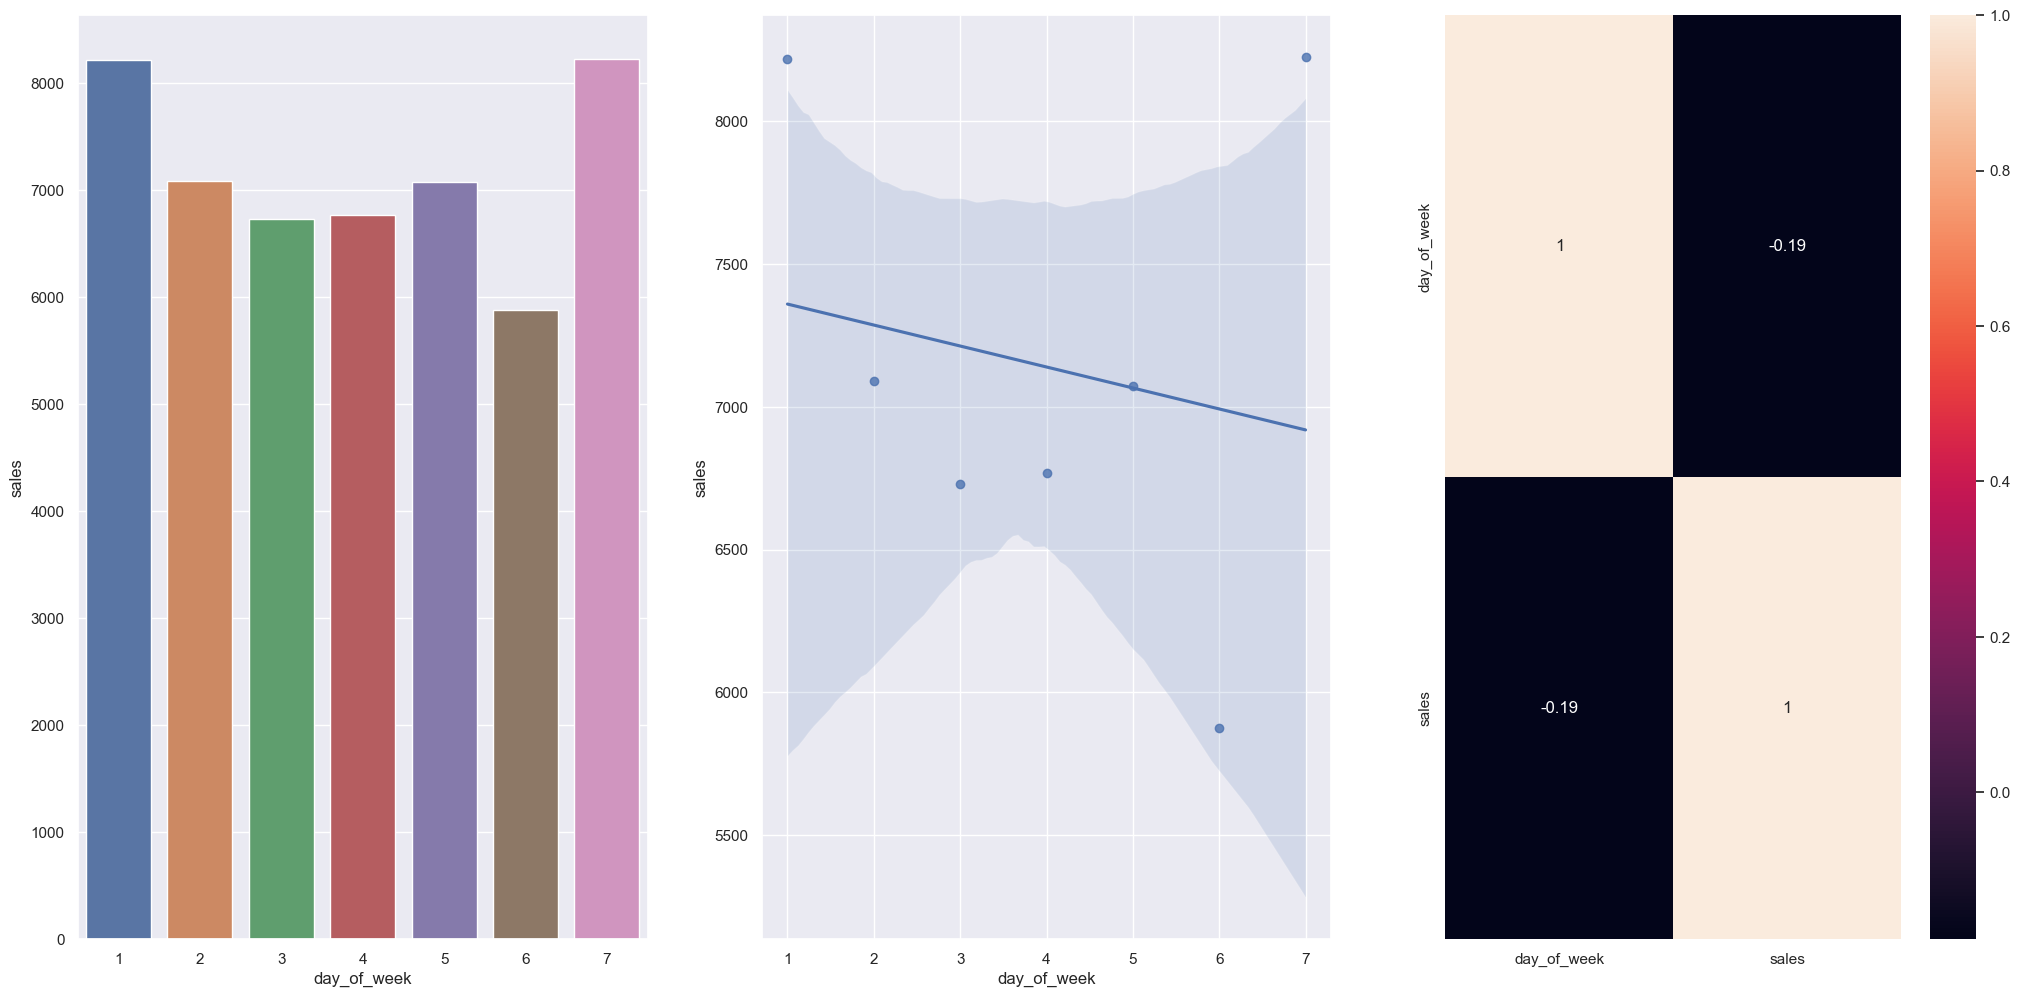

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# h11. Lojas deveriam vender menos durante feriados escolares
**Falso** Lojas vendem mais durante os feriados escolares.

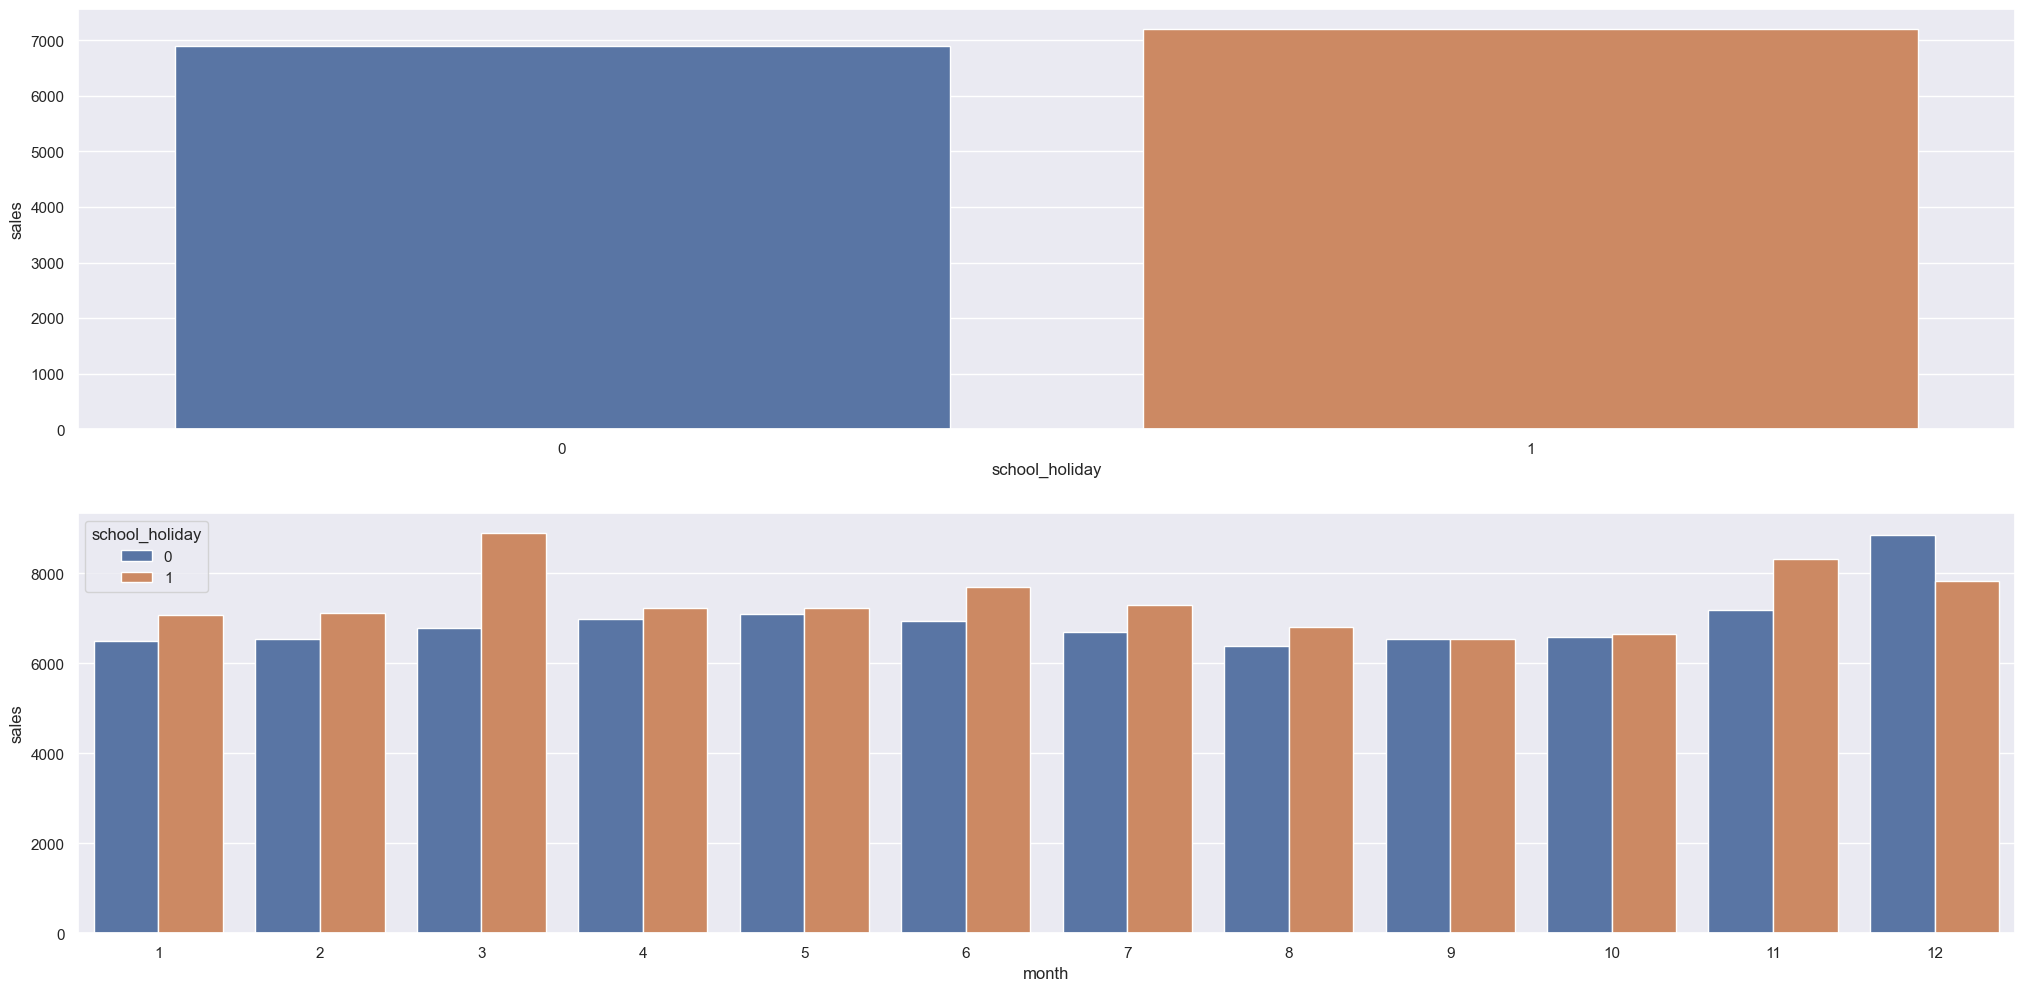

In [48]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

# 4.3 Análise Multivariada

# 4.3.1 Num Attributes

<AxesSubplot:>

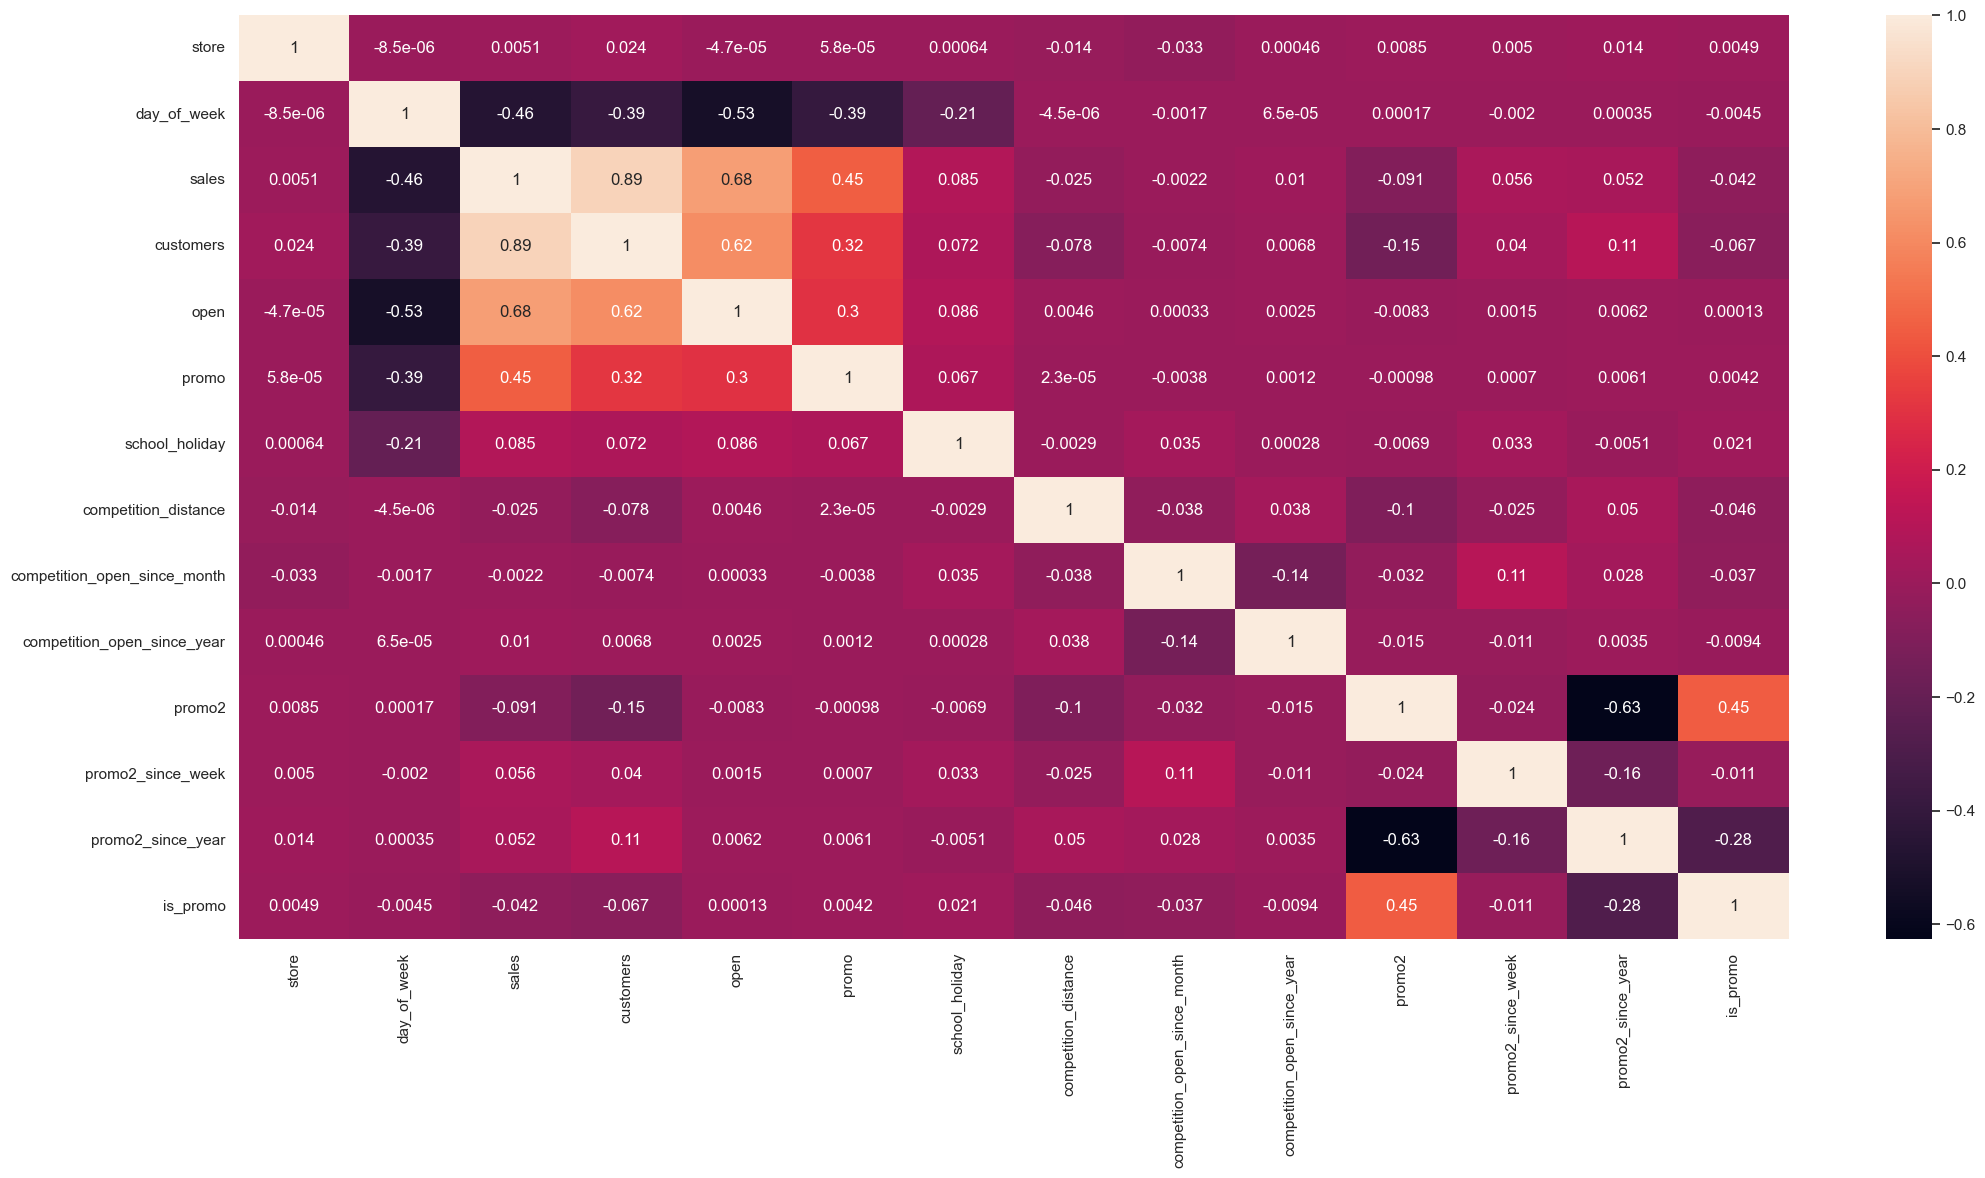

In [49]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

# 5.0 Preparação dos Dados

In [50]:
df5 = df4.copy()

# 5.1 Normalização

In [51]:
#olhando a análise variada, em especifico os atributos numéricos, não há nenhuma distribuição normal logo não vai ocorrer a normalização

# 5.2 Rescaling

Reescalar as variáveis numéricas do dataset para que não haja Ranges diferentes e isso afete na importância dada pelo modelo a essa variável.

In [52]:
a = df5.select_dtypes(include = ['float64','int32','int64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [53]:
#verificando os outliers para aplicar os metodos min/max ou robustescale
#sns.boxplot(df5['competition_distance'])
#sns.boxplot(df5['competition_time_month'])
#sns.boxplot(df5['promo_time_week'])

Quando se tem outliers destoando, aplicamos o robust Scaler pois o MinMax é sensivel aos outliers.

Já o RobustScaler deixa a distribuição mais 'apertada'.

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#year
df5['year'] = mms.fit_transform(df5[['year']].values)
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

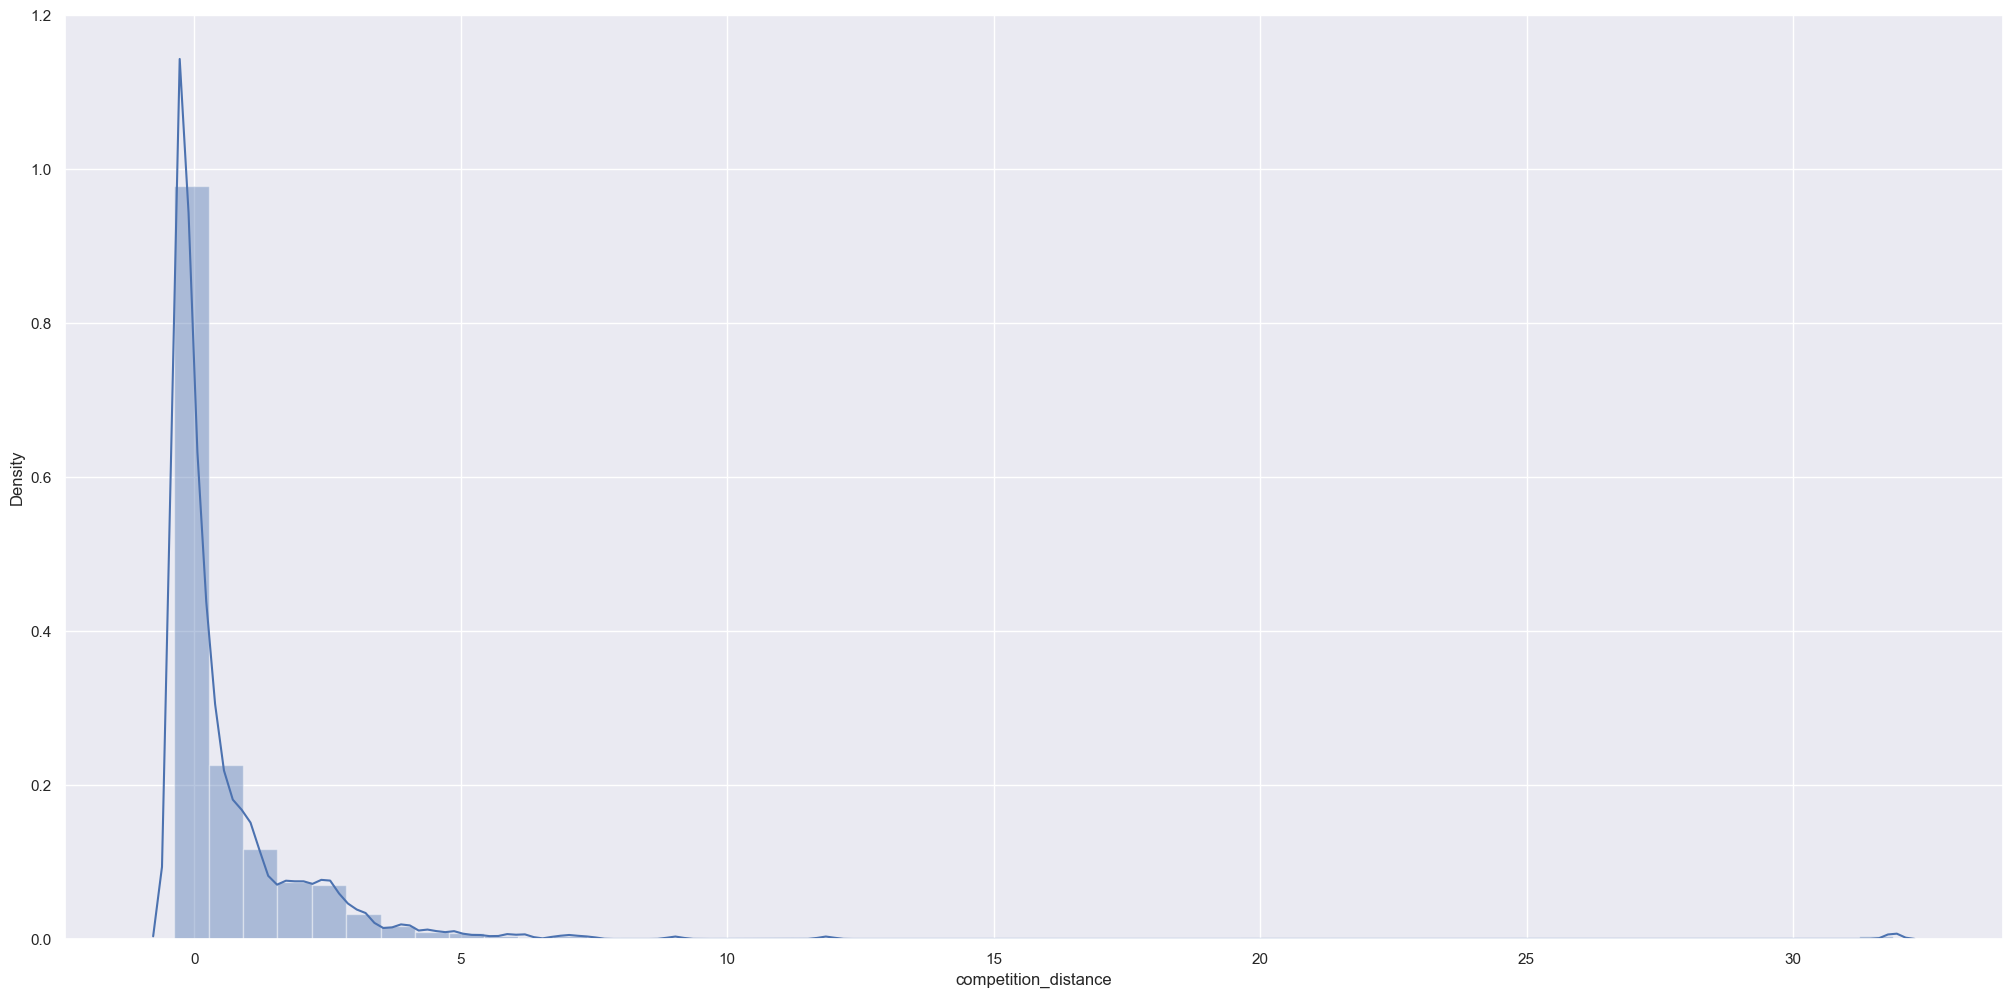

In [57]:
sns.distplot(df5['competition_distance'])

# 5.3 Transformação

# 5.3.1 Encoding
Transforma variáveis categóricas em numericas para que o modelo consiga atuar e compreender melhor os dados

In [ ]:
#state_holiday = One Hot encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'],columns = ['state_holiday'])
#store_type = laBel encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
#assortment = Ordinal encoding
assortment_dict = {'basic':1,
                   'extra':2,
                   'extended':3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

# 5.3.2 Response variable transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

# 5.3.3 Nature transformation Cíclico

As datas devem representar ciclos para o modelo de ML, então se apresenta las em alguma forma numérica pode resultar em uma imperfeição no modelo. Por exemplo, Dezembro é representado como 12 e janeiro como mês 01, o modelo não seria capaz de ler que dezembro é 1 mês antes de janeiro.

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )